<a href="https://colab.research.google.com/github/kimjoe1850/Lectures/blob/main/NLP/2.%20%ED%85%8D%EC%8A%A4%ED%8A%B8_%EC%88%98%EC%A7%91_%EB%B0%8F_%ED%82%A4%EC%9B%8C%EB%93%9C_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 텍스트 수집 및 키워드 분석

## 한글 폰트 설정

* 실행 후 런타임 재시작 필요

In [1]:
# 나눔고딕 설치, matplotlib에서 보여줄 수 있게 연동
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

%config InlineBackend.figure_format='retina'

!apt -qq -y install fonts-nanum

import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
plt.rc('font', family='NanumBarunGothic')
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


## 한국어 형태소 분석기 설치

* 한국어 자연어 처리 konlpy 라이브러리
* 형태소 분석기 MeCab 설치
* 설치 명령어: 
`!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash`

In [ ]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

## 키워드 분석(Keyword Analysis)

* 핵심어(keyword)란 텍스트 자료의 **중요한 내용을 압축적으로 제시**하는 단어 또는 문구
* 핵심어 분석이란 불용어 제거와 어간추출 및 형태소 분석 등의 자연어 처리를 시행한 후 텍스트에서 많이 등장하는 형태소의 등장 빈도를 분석함으로써 핵심어를 추출   
* **특정 텍스트 자료에 많이 나타나는 형태소가 그 텍스트 주제를 표출할 가능성이 높다**는 가정에 기초  
* 물론 빈도 분석에서 영어의 전치사나 한국어의 조사와 같이 의미를 별로 담고 있지 않은 불용어는 제외하는 것이 좋음
* 키워드 분석은 텍스트의 주제 추정, 텍스트 유사도, 검색 엔진의 검색 결과 우선 순위 측정 등 다양하게 사용될 수 있음

### 네이버 영화 리뷰 데이터

* 키워드 분석에는 네이버 영화 리뷰 데이터를 사용
* 데이터 다운로드: https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt

In [9]:
import urllib.request

raw = urllib.request.urlopen("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt").readlines()
print(raw[:5])

[b'id\tdocument\tlabel\n', b'8112052\t\xec\x96\xb4\xeb\xa6\xb4\xeb\x95\x8c\xeb\xb3\xb4\xea\xb3\xa0 \xec\xa7\x80\xea\xb8\x88\xeb\x8b\xa4\xec\x8b\x9c\xeb\xb4\x90\xeb\x8f\x84 \xec\x9e\xac\xeb\xb0\x8c\xec\x96\xb4\xec\x9a\x94\xe3\x85\x8b\xe3\x85\x8b\t1\n', b'8132799\t\xeb\x94\x94\xec\x9e\x90\xec\x9d\xb8\xec\x9d\x84 \xeb\xb0\xb0\xec\x9a\xb0\xeb\x8a\x94 \xed\x95\x99\xec\x83\x9d\xec\x9c\xbc\xeb\xa1\x9c, \xec\x99\xb8\xea\xb5\xad\xeb\x94\x94\xec\x9e\x90\xec\x9d\xb4\xeb\x84\x88\xec\x99\x80 \xea\xb7\xb8\xeb\x93\xa4\xec\x9d\xb4 \xec\x9d\xbc\xea\xb5\xb0 \xec\xa0\x84\xed\x86\xb5\xec\x9d\x84 \xed\x86\xb5\xed\x95\xb4 \xeb\xb0\x9c\xec\xa0\x84\xed\x95\xb4\xea\xb0\x80\xeb\x8a\x94 \xeb\xac\xb8\xed\x99\x94\xec\x82\xb0\xec\x97\x85\xec\x9d\xb4 \xeb\xb6\x80\xeb\x9f\xac\xec\x9b\xa0\xeb\x8a\x94\xeb\x8d\xb0. \xec\x82\xac\xec\x8b\xa4 \xec\x9a\xb0\xeb\xa6\xac\xeb\x82\x98\xeb\x9d\xbc\xec\x97\x90\xec\x84\x9c\xeb\x8f\x84 \xea\xb7\xb8 \xec\x96\xb4\xeb\xa0\xa4\xec\x9a\xb4\xec\x8b\x9c\xec\xa0\x88\xec\x97\x90 \xeb\x81\x9d

* 데이터를 확인해보면 모두 바이트로 이루어져 있으며, 리뷰 외의 다른 데이터도 존재
* 데이터를 문자열로 변환하고 리뷰만 추출

In [10]:
# 바이트로 된 데이터 디코딩
raw = [x.decode() for x in raw[1:]] # 1번째는 header정보로 필요가 없음

In [11]:
# 리뷰들만 모으기
reviews = []
for i in raw:
  reviews.append(i.split('\t')[1]) # split했을 때 document가 필요해서 [1]
print(reviews[:5])

['어릴때보고 지금다시봐도 재밌어요ㅋㅋ', '디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업이 부러웠는데. 사실 우리나라에서도 그 어려운시절에 끝까지 열정을 지킨 노라노 같은 전통이있어 저와 같은 사람들이 꿈을 꾸고 이뤄나갈 수 있다는 것에 감사합니다.', '폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.', '와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런게 진짜 영화지', '안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.']


In [12]:
# 긍정/부정 레이블
labels = []
for i in raw:
  labels.append(i.split('\t')[2]) # split했을 때 label이 필요해서 [2]
print(labels[:5])

['1\n', '1\n', '1\n', '1\n', '1\n']


### 형태소 분석을 이용한 명사 추출
* 핵심어는 주로 명사인 경우가 많음 -> 명사만 추출

* 형태소 분석기 Mecab으로 명사만 추출

In [13]:
from konlpy.tag import Mecab
tagger = Mecab()

reviews_nouns = []
for review in reviews:
  for noun in tagger.nouns(review):
    reviews_nouns.append(noun)

reviews_nouns[:10]

['때', '디자인', '학생', '외국', '디자이너', '그', '전통', '발전', '문화', '산업']

#### 불용어(Stopwords) 사전 만들기

* 형태소 분석을 통해 조사, 접속사 등의 제거 가능
* 하지만 한국어는 명사에서도 상당히 많은 불필요한 단어들이 포함
* 사용자가 직접 불용어 사전을 유지하면서 불필요한 단어 제거 필요
* 불용어 예: `전 난 일 걸 뭐 줄 만 건 분 개 끝 잼 이거 번 중 듯 때 게 내 말 나 수 거 점 것 후 이 애 씨 속 뿐 밋 그 급 ㄷ 데`
* 빈도가 너무 커서 분석에 방해되는 단어도 제거 필요 (예: `영화`)


In [16]:
stop_words = "영화 전 난 일 걸 뭐 줄 만 건 분 개 끝 잼 이거 번 중 듯 때 게 내 말 나 수 거 점 것 후 이 애 씨 속 뿐 밋 그 급 ㄷ 데"
stop_words = stop_words.split(' ')
print(stop_words)

['영화', '전', '난', '일', '걸', '뭐', '줄', '만', '건', '분', '개', '끝', '잼', '이거', '번', '중', '듯', '때', '게', '내', '말', '나', '수', '거', '점', '것', '후', '이', '애', '씨', '속', '뿐', '밋', '그', '급', 'ㄷ', '데']


#### 불용어를 제외하여 형태소 분석 수행

* 한글 텍스트에 대해서 형태소 분석 수행
* 분석으로 추출하는 명사 중에서 불용어에 포함되지 않은 텍스트만 추출하여 저장

In [18]:
reviews_nouns = []

for review in reviews:
  for noun in tagger.nouns(review):
    if noun not in stop_words: # 불용어가 아니면 추가
      reviews_nouns.append(noun)
reviews_nouns[:10]
# 우리, 나라의 경우 개체명 인식을 통해 하나로 합쳐서 나오게끔 분석 업그레이드 가능

['디자인', '학생', '외국', '디자이너', '전통', '발전', '문화', '산업', '우리', '나라']

### 단어 빈도수 측정

* 단어 빈도수 측정에는 `collections` 라이브러리의 `Counter` 함수를 이용
* `collections` 라이브러리는 내장 라이브러리로 별도 설치가 필요없음
* `counter`를 이용하면 각 단어와 각 단어의 빈도 수를 딕셔너리로 편리하게 생성 가능

In [ ]:
from collections import Counter

reviews_nouns_counter = Counter(reviews_nouns)
top_reviews_nouns = dict(reviews_nouns_counter.most_common(100))
top_reviews_nouns

### 단어 빈도 시각화

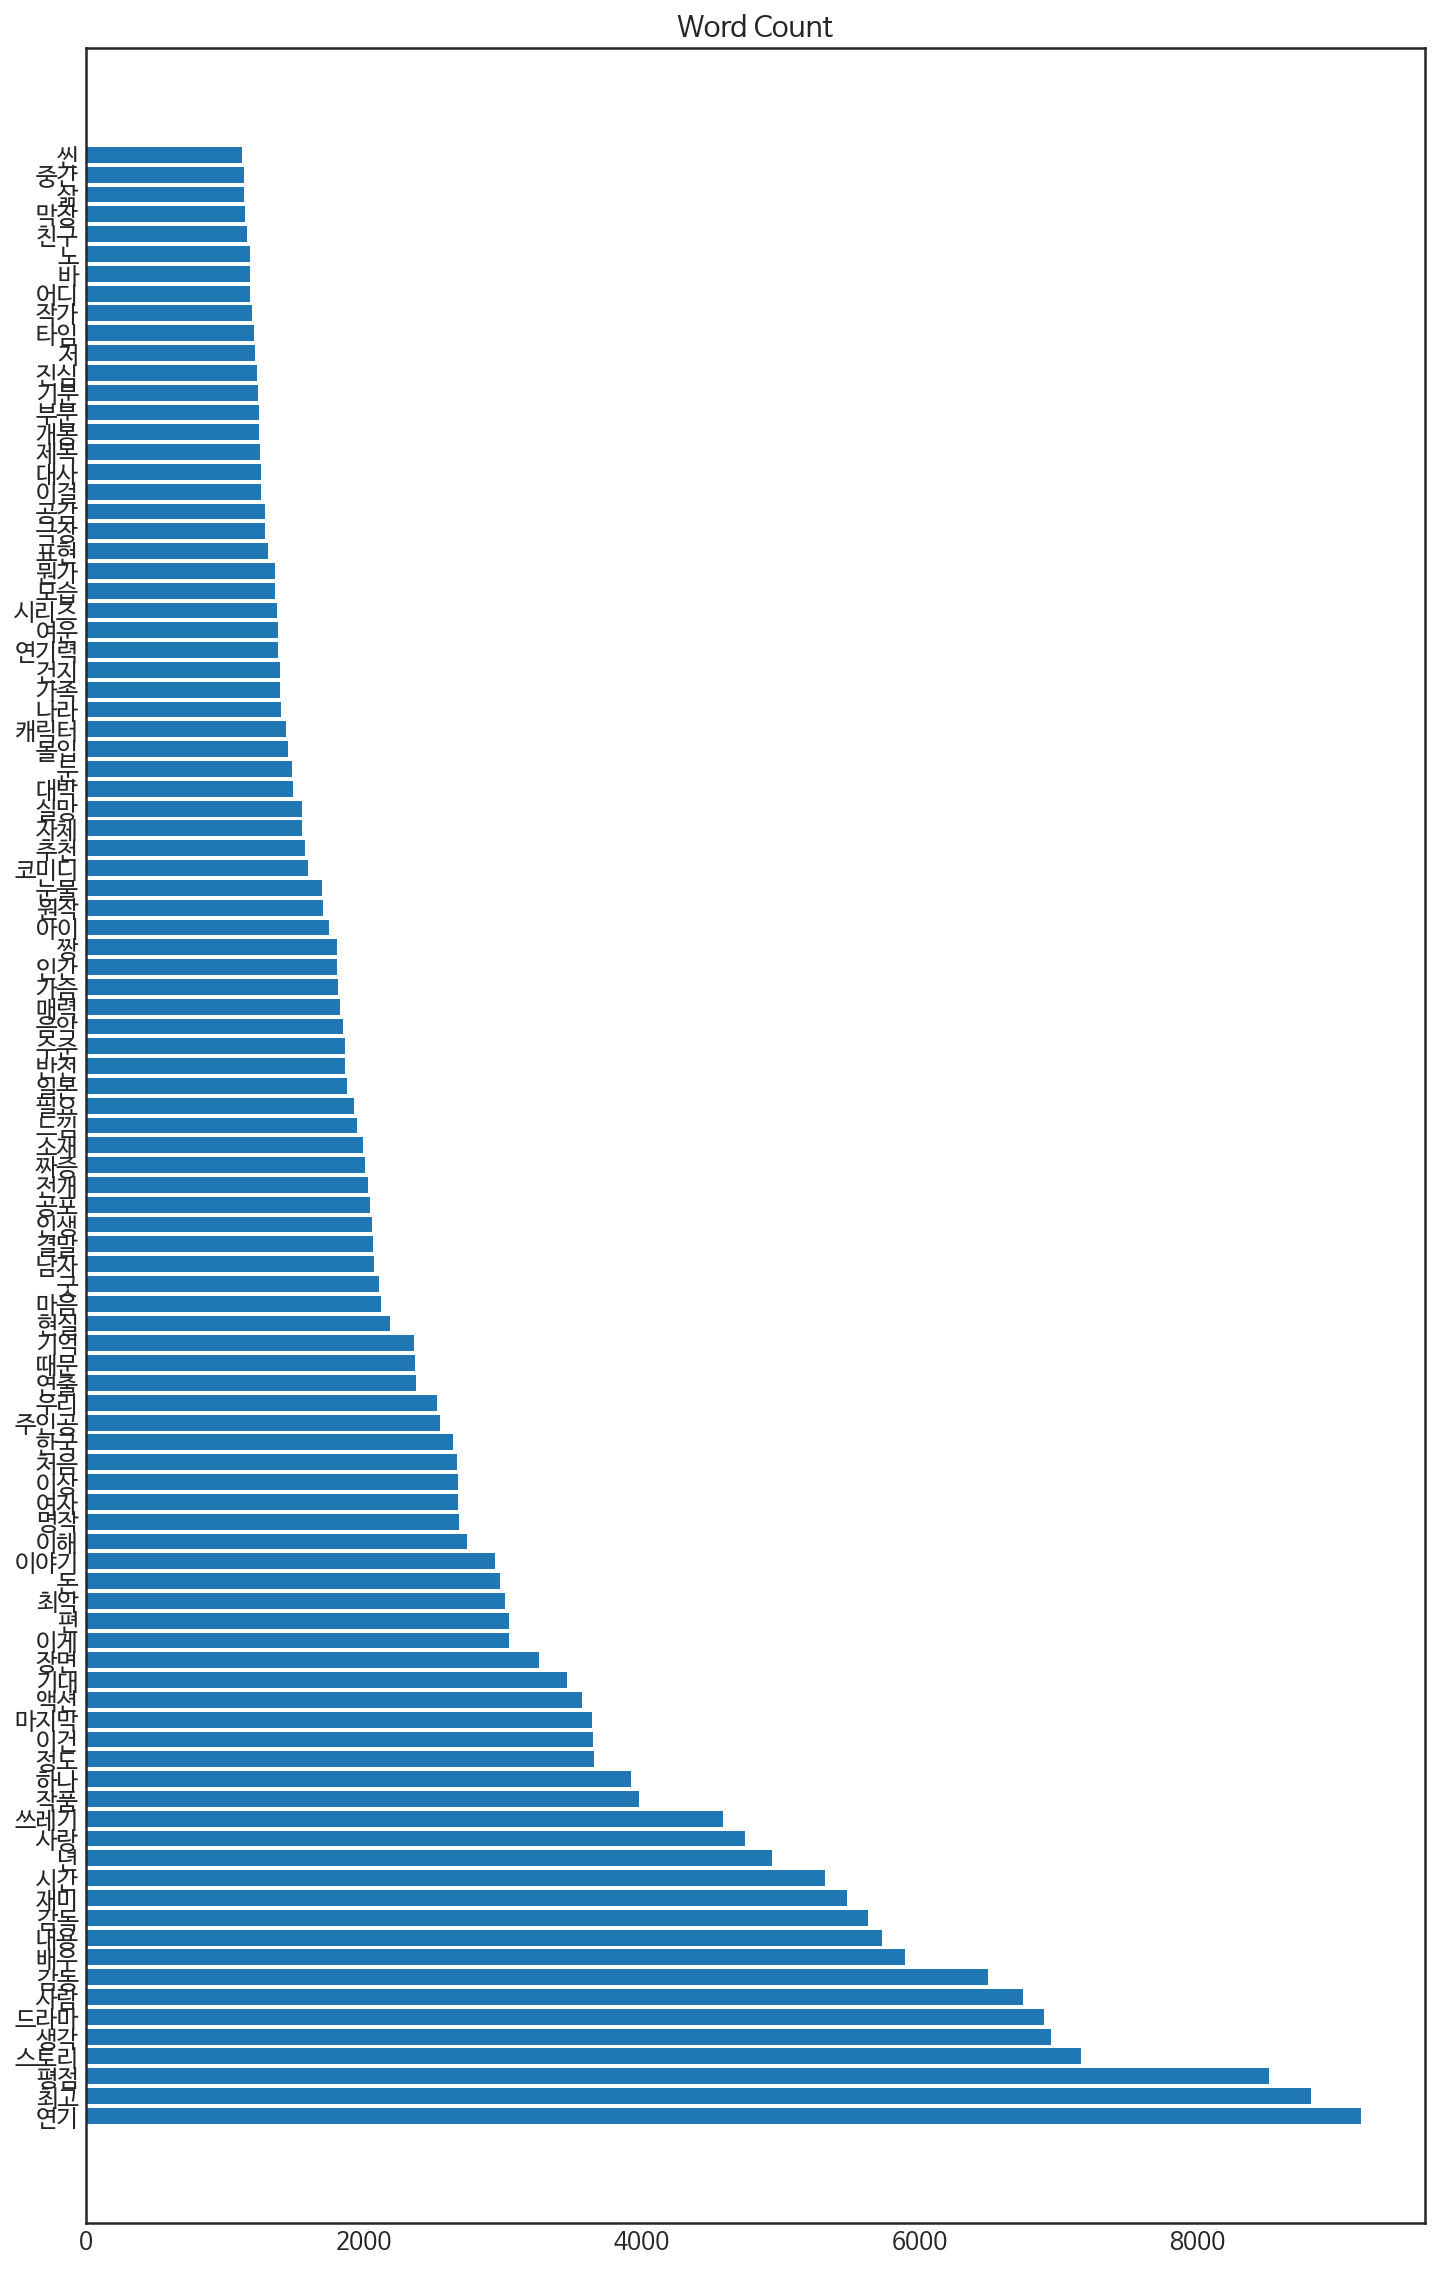

In [24]:
import numpy as np

plt.rcParams['font.size'] = 12
y_pos = np.arange(len(top_reviews_nouns)) # y축 개수->100개
plt.figure(figsize = (12,20))
plt.barh(y_pos, top_reviews_nouns.values()) # plt.barh(y축, x축)
plt.title("Word Count")
plt.yticks(y_pos, top_reviews_nouns.keys()) # y축 눈금
plt.show()

### 트리맵(Treemap) 시각화

* `squarify`는 트리맵 생성을 지원해주는 파이썬 라이브러리
* `squarify` 라이브러리를 이용해 키워드와 키워드 빈도 수를 트리맵으로 나타냄   

In [25]:
!pip install squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


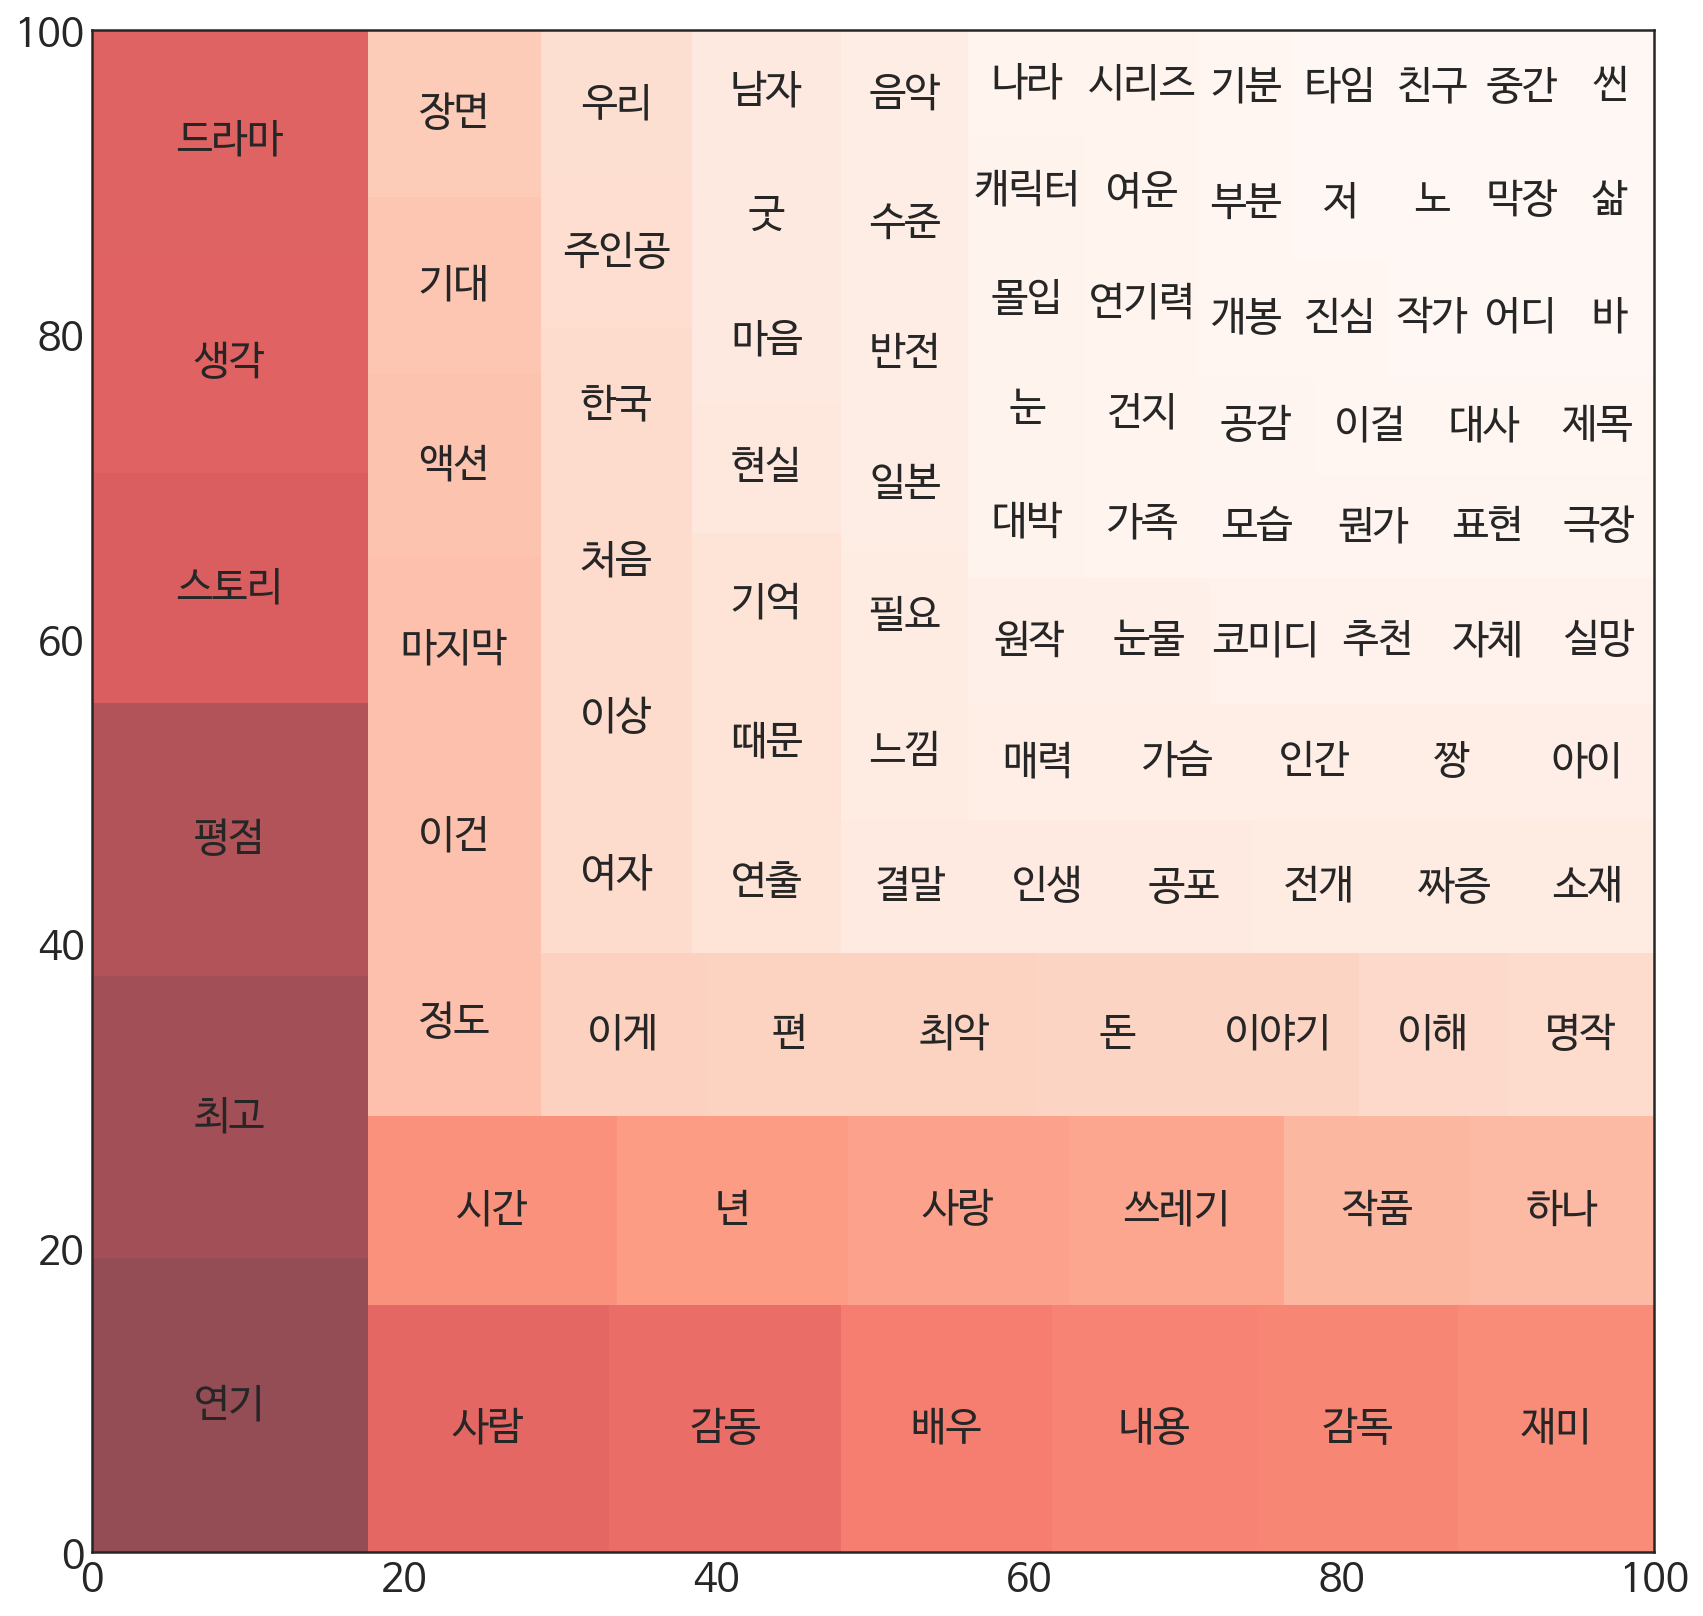

In [28]:
import squarify

# parameter 조정
plt.rcParams['figure.figsize'] = (14,14)
plt.rcParams['font.size'] = 20

# 정규화를 통한 컬러 조정 -> 색을 균등하게 하기 위해 빈도수에서 최소, 최대값으로 컬러 분포될 수 있도록 지정
norm = mpl.colors.Normalize(vmin = min(top_reviews_nouns.values()),
                            vmax = max(top_reviews_nouns.values()))

# 각각 무슨 컬러를 가질지를 리스트에 정규화를 통한 매칭의 결과값 저장(값, color)-> 값 클수록 컬러 진해짐
colors = [mpl.cm.Reds(norm(value)) for value in top_reviews_nouns.values()]

squarify.plot(label = top_reviews_nouns.keys(),
              sizes = top_reviews_nouns.values(),
              color = colors,
              alpha = 0.7)

# 키워드 분석의 장점 -> 우리가 수많은 리뷰를 보지 않고도 중요한 빈도에 해당하는 키워드를 보고 분석 가능

### 워드클라우드(WordCloud) 시각화

* 텍스트에 담겨있는 여러 형태소들의 등장 빈도를 가장 직관적으로 시각화하는 방법
* 텍스트에 등장하는 단어를 그 등장 빈도에 따라 서로 크기가 다르게 구름 형태로 표현함으로써, 단어의 빈도 수를 한번에 알 수 있음  
* 최근에 많은 서비스들이 어떤 핵심어가 많이 등장했는가를 워드클라우드 형식으로 시각화
* **빈도 수만을 시각적으로 표현**한 것이기 때문에, **단어들 사이의 연관성이나 의미 구조 등을 분석하는 데는 한계**가 있음

* 파이썬에서 워드 클라우드를 시각화하기 위해 `matplotlib` 라이브러리와 `WordCloud` 라이브러리를 `import` 해서 사용
* `WordCloud` 라이브러리는 `pip install wordcloud` 명령어를 통해 설치 필요

In [ ]:
!pip install wordcloud

* WordCloud를 이용해 객체를 생성해주고,
`generate_from_frequencies()` 함수로 빈도 수에 따라 워드클라우드 생성

In [39]:
from wordcloud import WordCloud

# wordcloud의 배경색, 폰트 설정
wc = WordCloud(background_color = 'white', font_path = '/font/NanumBarunGothic.ttf')
# top_reviews_nouns의 빈도수에 따라 wordcloud 생성
wc.generate_from_frequencies(top_reviews_nouns)

* 워드클라우드를 시각화할 때는 이미지 시각화 함수인 `imshow()` 함수를 사용해야 함

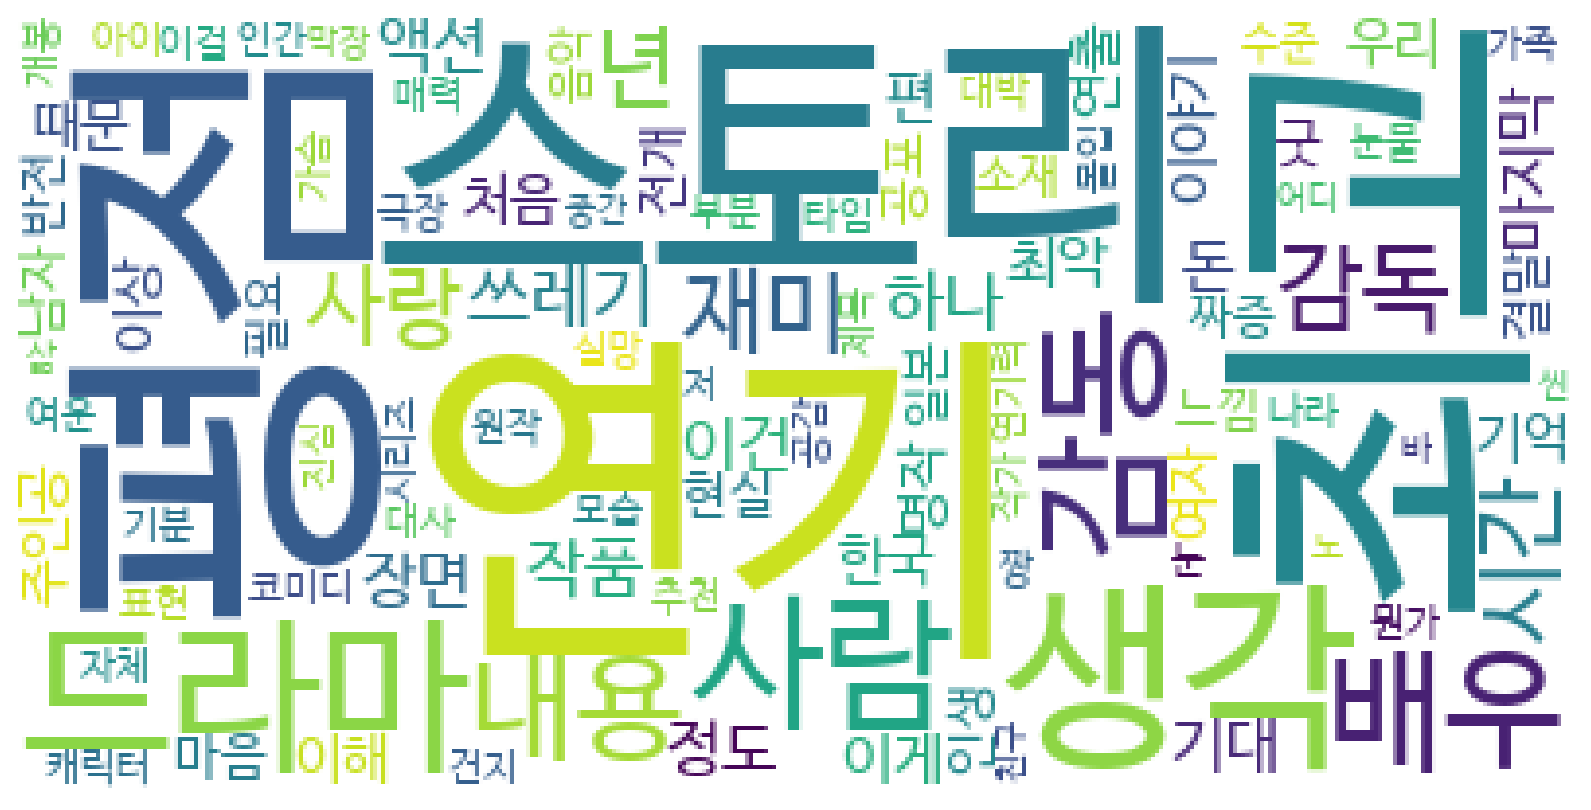

In [40]:
figure = plt.figure(figsize = (14,14))
ax = figure.add_subplot(1,1,1)
plt.axis('off')
ax.imshow(wc)
plt.show()

## 네이버 검색 API 서비스

### 네이버 서비스 API 신청

1. 네이버 개발자센터: https://developers.naver.com/
2. 어플리케이션 등록
3. 클라이언트 ID/SECRET 확인

### NAVER 서비스 API 종류

| 항목 | 주소                                         |
|------|----------------------------------------------|
|블로그| https://openapi.naver.com/v1/search/blog.json |
|뉴스　| https://openapi.naver.com/v1/search/news.json |
| 책　 | https://openapi.naver.com/v1/search/book.json|
| 성인 검색어 판별|　https://openapi.naver.com/v1/search/adult.json|
| 백과사전| https://openapi.naver.com/v1/search/encyc.json|
| 영화| https://openapi.naver.com/v1/search/movie.json|
| 카페글 |https://openapi.naver.com/v1/search/cafearticle.json|
| 지식in| https://openapi.naver.com/v1/search/kin.json|
| 지역 | https://openapi.naver.com/v1/search/local.json|
| 오타변환 | https://openapi.naver.com/v1/search/errata.json|
| 웹문서 | https://openapi.naver.com/v1/search/webkr.json|
| 이미지 | https://openapi.naver.com/v1/search/image.json|
| 쇼핑 | https://openapi.naver.com/v1/search/shop.json|
| 전문자료 | https://openapi.naver.com/v1/search/doc.json|

## 네이버 웹문서 키워드 분석

### 네이버 웹문서 검색 API

In [42]:
import os
import sys
import urllib.request
import pandas as pd # 웹문서 받아온거 테이블 형태로 보기 위해
import json
import re

# 권한이 있는 사용자임을 명시
client_id = "B5YuqXvMWJ5YN3Rch9d4"
client_secret = "lhH_rcPIxu"

query = urllib.parse.quote(input("검색 질의 : "))
idx = 0
display = 100
start = 1
end = 1000 # 네이버가 한번 검색했을 때 나오는 최대 건수

# 결과를 넣을 데이터프레임 -> title, link description
web_df = pd.DataFrame(columns=('Title', "Link", "Description"))

for start_index in range(start, end, display):

  url = "https://openapi.naver.com/v1/search/webkr?query=" + query \
        + '&display=' + str(display) + "&start=" + str(start_index)
  
  # 요청하기
  request = urllib.request.Request(url)
  request.add_header('X-Naver-Client-id', client_id)
  request.add_header('X-Naver-Client-Secret', client_secret)
  # 요청의 결과를 response에 저장
  response = urllib.request.urlopen(request)
  rescode = response.getcode() # 코드 정상적으로 되었는지 코드 반환, 200번이면 정상 아니면 비정상

  # 요청의 정상인 경우
  if(rescode == 200):
    response_body = response.read() # 정상이면 결과 읽어오기
    response_dict = json.loads(response_body.decode('utf-8'))
    # json으로 결과가 오기 때문에 디코드를 통해 utf-8로 디코딩
    items = response_dict['items'] 
    # 우리가 필요한건 개별 검색 결과인 items -> 안에 title, link description포함
    for item_index in range(0, len(items)):
      remove_tag = re.compile('<.*?>')
      # title
      title = re.sub(remove_tag, '',items[item_index]['title'])
      # 불필요한 태그에 대한 특수문자 제거

      # link
      link = items[item_index]['link']

      # description
      description = re.sub(remove_tag, "",items[item_index]['description'])
      # title과 마찬가지로 불필요한 특수문자 제거

      # 나온 값을 데이터프레임(web_df)에 넣기
      web_df.loc[idx] = [title, link, description]
      # 다음 행에 넣게끔 1씩 증가
      idx += 1 

  # 요청이 비정상인 경우
  else:
    print("Error Code : " + rescode)

web_df # 웹페이지 제목, 링크, 설명 반환

검색 질의 : 인공지능


,Title,Link,Description
0,인공지능 - 나무위키,https://namu.wiki/w/%EC%9D%B8%EA%B3%B5%EC%A7%8...,인공지능(人工知能) 또는 A.I.(Artificial Intelligence)는 일...
1,인공지능의 정의와 활용 방안 | SAS KOREA,https://www.sas.com/ko_kr/insights/analytics/w...,"SAS에서 인공지능(Artificial Intelligence)의 정의와 중요성, ..."
2,인공지능 - 해시넷,http://wiki.hash.kr/index.php/%EC%9D%B8%EA%B3%...,"인공지능(AI) 인공지능(人工知能, AI, artificial intelligenc..."
3,인공 지능(AI)이란? | 용어 해설 | HPE 대한민국,https://www.hpe.com/kr/ko/what-is/artificial-i...,AI(인공 지능)는 광범위하게 기계 또는 시스템이 하는 인간과 같은 모든 행동을 의...
4,바둑/인공지능 - 나무위키,https://namu.wiki/w/%EB%B0%94%EB%91%91/%EC%9D%...,지금까지 사용되었던 바둑프로그램의 인공지능을 요약하면 다음과 같다. 출처는 기사를 ...
...,...,...,...
745,인공지능 - YES24,http://www.yes24.com/Product/Goods/3768584,청소년 교양필독서로 현대 과학기술의 집약체라 할 수 있는 인공지능 대해 안내한다. ...
746,브리태니커 만화 백과 51: 인공지능 - 싸니까 믿으니까 인터파크도서,https://book.interpark.com/product/BookDisplay...,"슬기와 로운이, 브리와 함께 인공지능의 역사, 인공지능의 활용, 제4차 산업 혁명 ..."
747,인공지능 관상보기,https://gwansang.netlify.app/,인공지능으로 얼굴 사진을 분석해서 관상을 무료로 알려줍니다
748,"인공지능 가스 자동차단기 타이머,헤스타 디벨!",https://blog.naver.com/hesta1,"약 4.1천 명의 구독자를 보유한 인공지능 가스 자동차단기 타이머,헤스타 디벨!(h..."


In [45]:
# Description만 모으기
web = []
for d in web_df.Description:
  web.append(d)
print(web[:5])

['인공지능(人工知能) 또는 A.I.(Artificial Intelligence)는 일반적으로 인간의 학습능력, 추론능력, 지각능력이 필요한 작업을 할 수 있도록 컴퓨터시스템을 구현하려는 컴퓨터과학의 세부분야 중 하나이다. 인간을 포함한 동물이 갖고 있는 지능 즉, natural intelligence와는 다른 개념이다.', 'SAS에서 인공지능(Artificial Intelligence)의 정의와 중요성, AI의 역사와 활용 방법에 대해서 알아 보실 수 있습니다.', '인공지능(AI) 인공지능(人工知能, AI, artificial intelligence)이란 인간처럼 학습하고 생각할 수 있는 컴퓨터 시스템을 말한다.', 'AI(인공 지능)는 광범위하게 기계 또는 시스템이 하는 인간과 같은 모든 행동을 의미합니다. AI의 기본 형식에서 컴퓨터는 과거의 유사한 행동 사례를 통해 얻은 광범위한 데이터를 사용하여 인간의 행동을 ‘모방’하도록 프로그래밍됩니다. | HPE 대한민국', '지금까지 사용되었던 바둑프로그램의 인공지능을 요약하면 다음과 같다. 출처는 기사를 참고, 요약했다.']


### 형태소 분석을 이용한 명사 추출


#### 불용어 사전

불용어 예제: `인공지능 인공 지능 분야 수 것 등 기반 일 년 말 문 월 이 명 깨 개 중 범 부 딥 빅 책 분 봉 차 나 내 전 억 대 형 선 사 폼 원 번`

* 인공지능, 인공, 지능은 빈도가 높아서 불용어에 포함

In [47]:
stop_words = '인공지능 인공 지능 분야 수 것 등 기반 일 년 말 문 월 이 명 깨 개 중 범 부 딥 빅 책 분 봉 차 나 내 전 억 대 형 선 사 폼 원 번'
stop_words = stop_words.split(' ')
print(stop_words)

['인공지능', '인공', '지능', '분야', '수', '것', '등', '기반', '일', '년', '말', '문', '월', '이', '명', '깨', '개', '중', '범', '부', '딥', '빅', '책', '분', '봉', '차', '나', '내', '전', '억', '대', '형', '선', '사', '폼', '원', '번']


In [49]:
tagger = Mecab() # Mecab을 이용한 형태소 분석
web_nouns = []
for w in web:
  for noun in tagger.nouns(w):
    if noun not in stop_words:
      web_nouns.append(noun)
print(web_nouns[:10])

['人工', '知能', '일반', '인간', '학습', '능력', '추론', '능력', '지각', '능력']


### 단어 빈도수 측정

In [ ]:
web_nouns_counter = Counter(web_nouns)
top_web_nouns = dict(web_nouns_counter.most_common(100))
top_web_nouns

### 단어 빈도 시각화

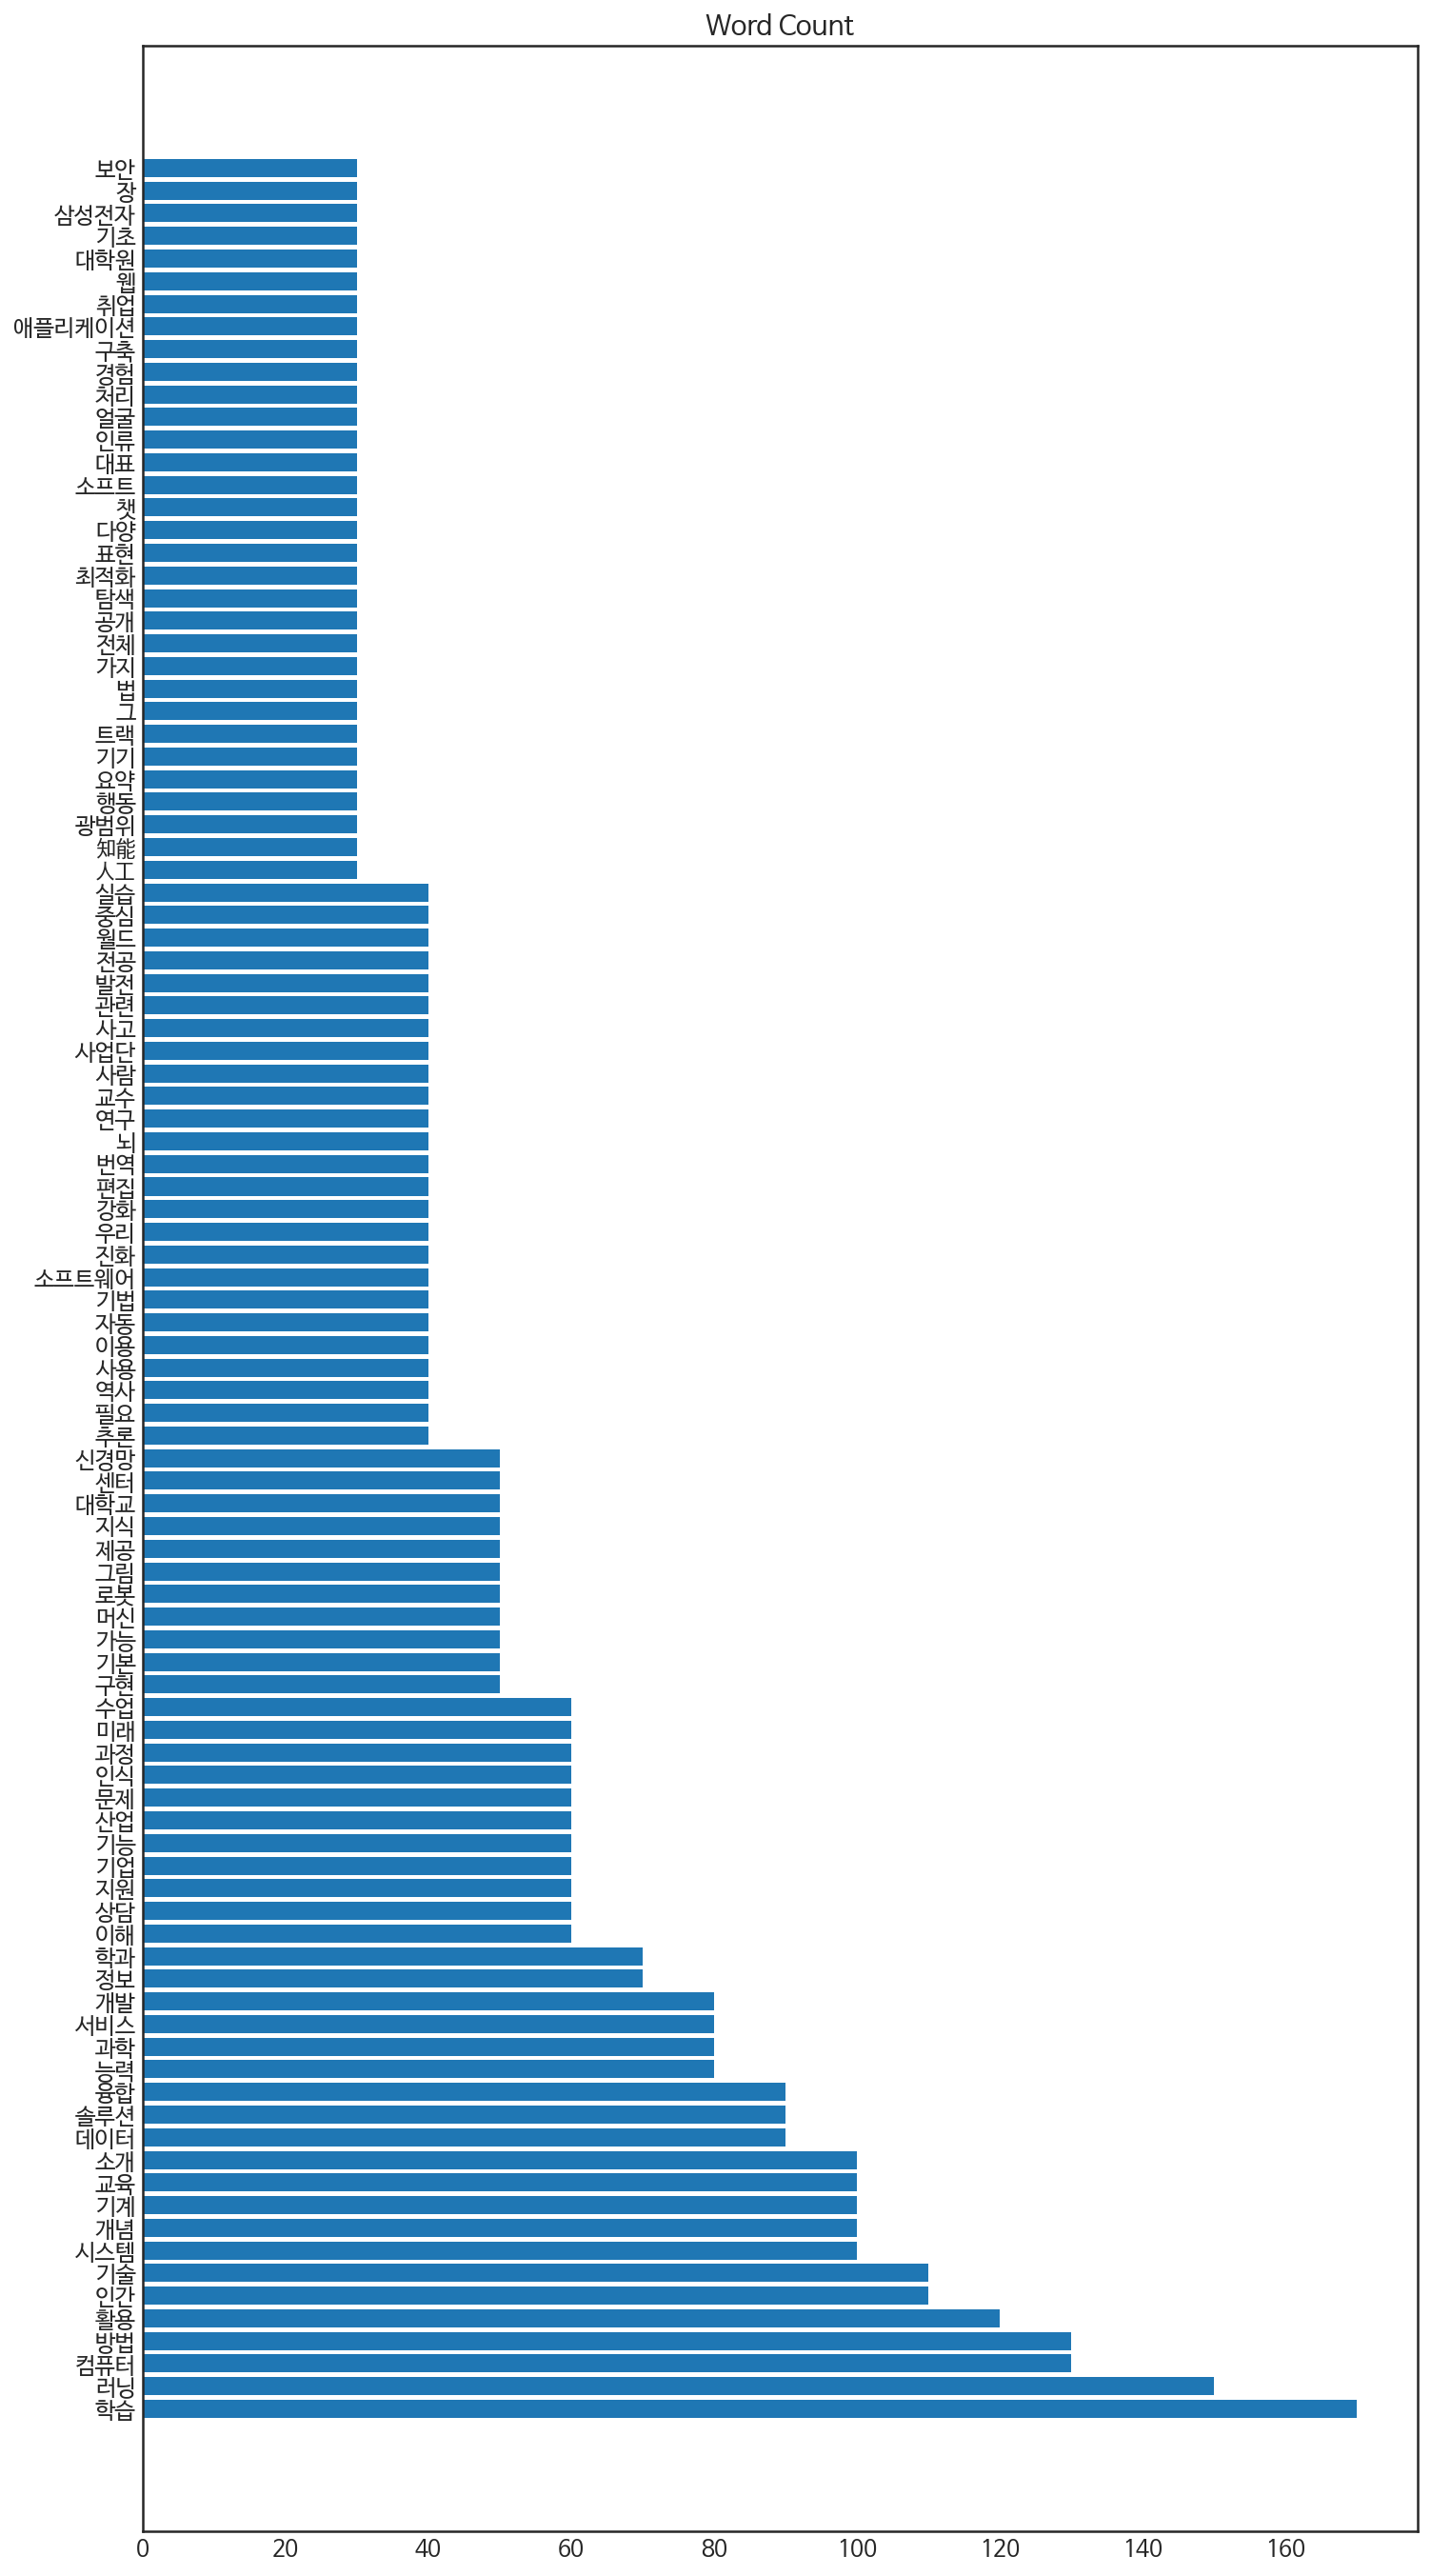

In [56]:
plt.rcParams['font.size'] = 12
y_pos = np.arange(len(top_web_nouns)) # y축 개수->100개
plt.figure(figsize = (12,24))
plt.barh(y_pos, top_web_nouns.values()) # plt.barh(y축, x축)
plt.title("Word Count")
plt.yticks(y_pos, top_web_nouns.keys()) # y축 눈금
plt.show()

### 트리맵 시각화

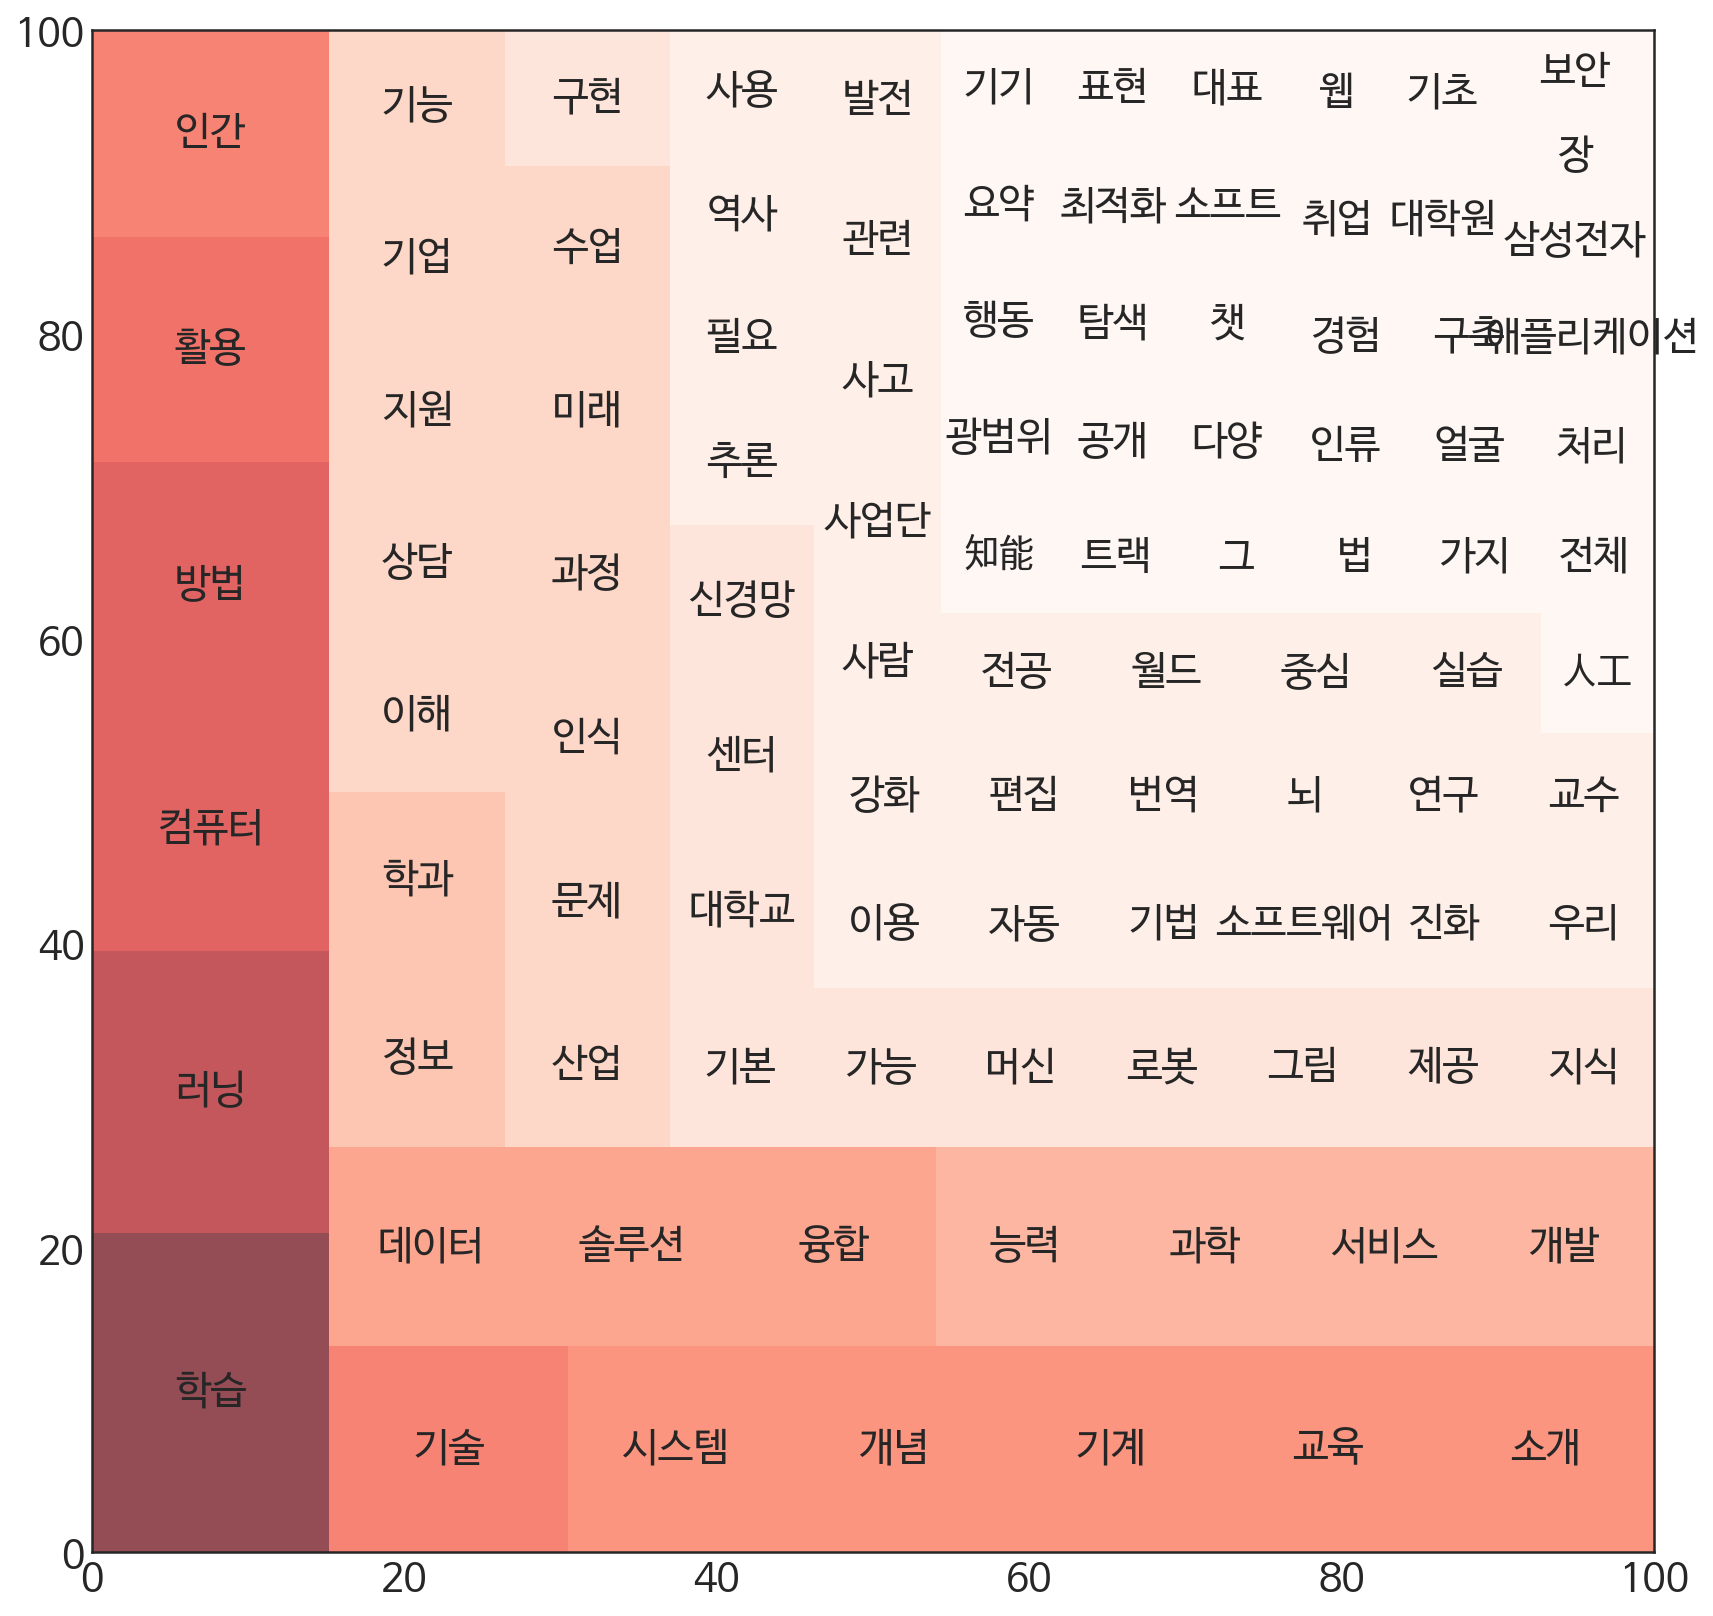

In [57]:
import squarify

# parameter 조정
plt.rcParams['figure.figsize'] = (14,14)
plt.rcParams['font.size'] = 20

# 정규화를 통한 컬러 조정 -> 색을 균등하게 하기 위해 빈도수에서 최소, 최대값으로 컬러 분포될 수 있도록 지정
norm = mpl.colors.Normalize(vmin = min(top_web_nouns.values()),
                            vmax = max(top_web_nouns.values()))

# 각각 무슨 컬러를 가질지를 리스트에 정규화를 통한 매칭의 결과값 저장(값, color)-> 값 클수록 컬러 진해짐
colors = [mpl.cm.Reds(norm(value)) for value in top_web_nouns.values()]

squarify.plot(label = top_web_nouns.keys(),
              sizes = top_web_nouns.values(),
              color = colors,
              alpha = 0.7)

### 워드클라우드 시각화

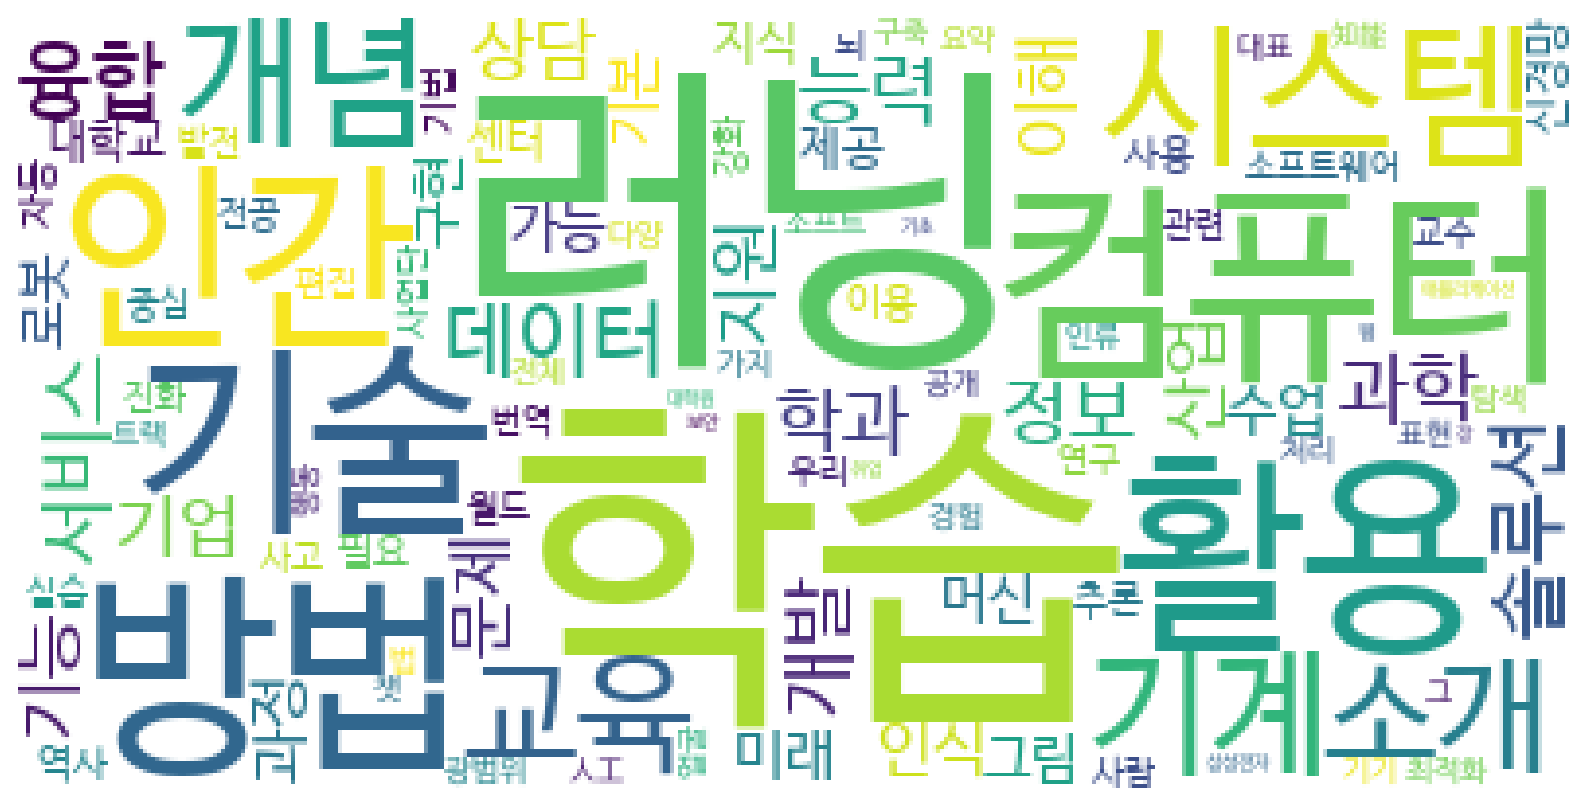

In [59]:
# wordcloud의 배경색, 폰트 설정
wc = WordCloud(background_color = 'white', font_path = '/font/NanumBarunGothic.ttf')
# top_reviews_nouns의 빈도수에 따라 wordcloud 생성
wc.generate_from_frequencies(top_web_nouns)

figure = plt.figure(figsize = (14,14))
ax = figure.add_subplot(1,1,1)
plt.axis('off')
ax.imshow(wc)
plt.show()

## 네이버 뉴스 키워드 분석

### 네이버 뉴스 검색 API

In [60]:
# 권한이 있는 사용자임을 명시
client_id = "B5YuqXvMWJ5YN3Rch9d4"
client_secret = "lhH_rcPIxu"

query = urllib.parse.quote(input("검색 질의 : "))
idx = 0
# parameters
display = 100
start = 1
end = 1000 # 네이버가 한번 검색했을 때 나오는 최대 건수
sort = 'sim' # 검색 결과 정렬 방법 - 정확도순(sim)으로 내림차순

# 결과를 넣을 데이터프레임 -> title, originallink, link ,description, pubDate
news_df = pd.DataFrame(columns=('Title', "Original Link", "Link", "Description", "Publication Date"))

for start_index in range(start, end, display):

  url = "https://openapi.naver.com/v1/search/news?query=" + query \
        + '&display=' + str(display) + "&start=" + str(start_index) + "&sort=" + sort
  
  # 요청하기
  request = urllib.request.Request(url)
  request.add_header('X-Naver-Client-id', client_id)
  request.add_header('X-Naver-Client-Secret', client_secret)
  # 요청의 결과를 response에 저장
  response = urllib.request.urlopen(request)
  rescode = response.getcode() # 코드 정상적으로 되었는지 코드 반환, 200번이면 정상 아니면 비정상

  # 요청의 정상인 경우
  if(rescode == 200):
    response_body = response.read() # 정상이면 결과 읽어오기
    response_dict = json.loads(response_body.decode('utf-8'))
    # json으로 결과가 오기 때문에 디코드를 통해 utf-8로 디코딩
    items = response_dict['items'] 
    # 우리가 필요한건 개별 검색 결과인 items -> 안에 title, originallink, link ,description, pubDate포함
    for item_index in range(0, len(items)):
      remove_tag = re.compile('<.*?>')
      # title
      title = re.sub(remove_tag, '',items[item_index]['title'])
      # 불필요한 태그에 대한 특수문자 제거

      # Originallink
      original_link = items[item_index]['originallink']

      # link
      link = items[item_index]['link']

      # pubDate
      pub_date = items[item_index]['pubDate']

      # description
      description = re.sub(remove_tag, "",items[item_index]['description'])
      # title과 마찬가지로 불필요한 특수문자 제거

      # 나온 값을 데이터프레임(news_df)에 넣기
      news_df.loc[idx] = [title, original_link, link, description, pub_date]
      # 다음 행에 넣게끔 1씩 증가
      idx += 1 

  # 요청이 비정상인 경우
  else:
    print("Error Code : " + rescode)

news_df 

검색 질의 : 인공지능


,Title,Original Link,Link,Description,Publication Date
0,"성인 실명, ‘인공지능 안저검사’로 조기 발견한다!",https://www.busan.com/view/busan/view.php?code...,https://n.news.naver.com/mnews/article/082/000...,오는 3월부터 부산 시내 일선 보건소에서 인공지능을 기반으로 한 안저검사를 받을 수...,"Wed, 18 Jan 2023 10:49:00 +0900"
1,"시, 지역 보건소 16곳에 &apos;인공지능 안저검사&apos; 도입",http://www.fnnews.com/news/202301181832365019,https://n.news.naver.com/mnews/article/014/000...,부산시는 오는 3월부터 부산 시내 16곳의 구군 보건소에서 인공지능(AI) 기반 안...,"Wed, 18 Jan 2023 18:33:00 +0900"
2,"인공지능 챗봇, 코로나 정보전달 역할 넘어 불안감 해소 도와",https://www.yna.co.kr/view/AKR2023011805450006...,https://n.news.naver.com/mnews/article/001/001...,"IBS 공동연구진, 챗봇 서비스 &apos;심심이&apos; 사용 상위 5개국 데이...","Wed, 18 Jan 2023 10:29:00 +0900"
3,“AI 유방암 진단 믿을만하네”…인공지능·전문의 같은 판단,http://www.newsis.com/view/?id=NISX20230118_00...,https://n.news.naver.com/mnews/article/003/001...,교수팀이 인공지능 판독 보조프로그램을 활용한 유방암 위험도 분석의 효용성을 확인했다...,"Wed, 18 Jan 2023 15:25:00 +0900"
4,"[특징주] KT, 초거대 인공지능 서비스 추진 소식에 강세",https://biz.chosun.com/stock/market_trend/2023...,https://n.news.naver.com/mnews/article/366/000...,초거대 인공지능(AI) 서비스를 내놓겠다는 소식에 매수세가 몰린 영향으로 풀이된다....,"Wed, 18 Jan 2023 09:49:00 +0900"
...,...,...,...,...,...
995,"정보통신기획평가원, 인공지능 등 6대 핵심 기술중심 조직 개편... &apos;AI...",https://www.aitimes.kr/news/articleView.html?i...,https://www.aitimes.kr/news/articleView.html?i...,"전성배 원장(사진:본지DB) 정보통신기획평가원(IITP, 원장 전성배)은 ICT R...","Sun, 01 Jan 2023 20:20:00 +0900"
996,기술을 넘어 사람을 대신하는 인공지능 기술,https://science.ytn.co.kr/program/view.php?mcd...,https://science.ytn.co.kr/program/view.php?mcd...,■ 기술을 넘어 사람을 대신하는 인공지능 기술 ■ 설탕이 부풀어 오른다? ■ 대한민...,"Tue, 20 Dec 2022 13:36:00 +0900"
997,&quot;책임있는 인공지능에 대하여&quot;…AI 법제정비단 공개 세미나 개최,https://www.aitimes.kr/news/articleView.html?i...,https://www.aitimes.kr/news/articleView.html?i...,"이하, NIA)은 22일( 서울 전경련회관 컨퍼런스센터 에메랄드홀에서 &apos;책...","Thu, 22 Dec 2022 15:48:00 +0900"
998,인공지능 분석 솔루션으로 &apos;아토피&apos;도 맞춤 관리,http://www.k-health.com/news/articleView.html?...,http://www.k-health.com/news/articleView.html?...,중 인공지능 학습에 활용 가능한 17만여건의 원천 데이터를 확보해 솔루션을 개발했다...,"Fri, 23 Dec 2022 13:56:00 +0900"


In [61]:
news = []
for n in news_df.Title:
  news.append(n)
print(news[:5])

['성인 실명, ‘인공지능 안저검사’로 조기 발견한다!', '시, 지역 보건소 16곳에 &apos;인공지능 안저검사&apos; 도입', '인공지능 챗봇, 코로나 정보전달 역할 넘어 불안감 해소 도와', '“AI 유방암 진단 믿을만하네”…인공지능·전문의 같은 판단', '[특징주] KT, 초거대 인공지능 서비스 추진 소식에 강세']


### 형태소 분석을 이용한 명사 추출


In [62]:
tagger = Mecab() # Mecab을 이용한 형태소 분석
news_nouns = []
for n in news:
  for noun in tagger.nouns(n):
    if noun not in stop_words:
      news_nouns.append(noun)
print(news_nouns[:10])

['성인', '실명', '안저', '검사', '조기', '발견', '시', '지역', '보건소', '곳']


### 단어 빈도수 측정

In [63]:
news_nouns_counter = Counter(news_nouns)
top_news_nouns = dict(news_nouns_counter.most_common(100))
top_news_nouns

{'교육': 105,
 '개발': 99,
 '기술': 71,
 '데이터': 65,
 '광주': 57,
 '미래': 53,
 '챗': 52,
 '시스템': 52,
 '서비스': 49,
 '로봇': 47,
 '활용': 45,
 '기업': 44,
 '모집': 43,
 '봇': 42,
 '정보': 41,
 '구축': 37,
 '학교': 37,
 '솔루션': 35,
 '융합': 33,
 '국민카드': 32,
 '마케팅': 32,
 '투자': 32,
 '광주시': 32,
 '연구': 32,
 '발명자': 32,
 '의료': 30,
 '병원': 30,
 '협약': 28,
 '스타트업': 28,
 '산업': 28,
 '연구소': 28,
 '도입': 26,
 '반도체': 26,
 '디지털': 26,
 '판독': 25,
 '팀': 25,
 '사업': 25,
 '관리': 24,
 '사관': 24,
 '실리콘밸리': 24,
 '모델': 24,
 '임': 23,
 '즈': 23,
 '스마트': 23,
 '리포트': 23,
 '학습': 22,
 '지원': 22,
 '진출': 22,
 '인식': 22,
 '셋': 22,
 '증권': 22,
 '대학': 21,
 '오픈': 21,
 '시대': 21,
 '교수': 21,
 '올해': 21,
 '강화': 21,
 '선정': 21,
 '제공': 21,
 '예술': 20,
 '도시': 20,
 '예측': 20,
 '업무': 20,
 '메타': 20,
 '공개': 20,
 '학과': 19,
 '방역': 19,
 '전문': 18,
 '처리': 18,
 '협력': 18,
 '위': 18,
 '버스': 18,
 '특허청': 18,
 '운영': 18,
 '최초': 18,
 '협회': 17,
 '한국': 17,
 '뉴스': 17,
 '혁신': 17,
 '세계': 17,
 '캠프': 17,
 '구현': 16,
 '수상': 16,
 '대회': 16,
 '재난': 16,
 '논문': 16,
 '양성': 15,
 '충남': 15,
 '경기': 15,
 '플랫': 

### 단어 빈도 시각화

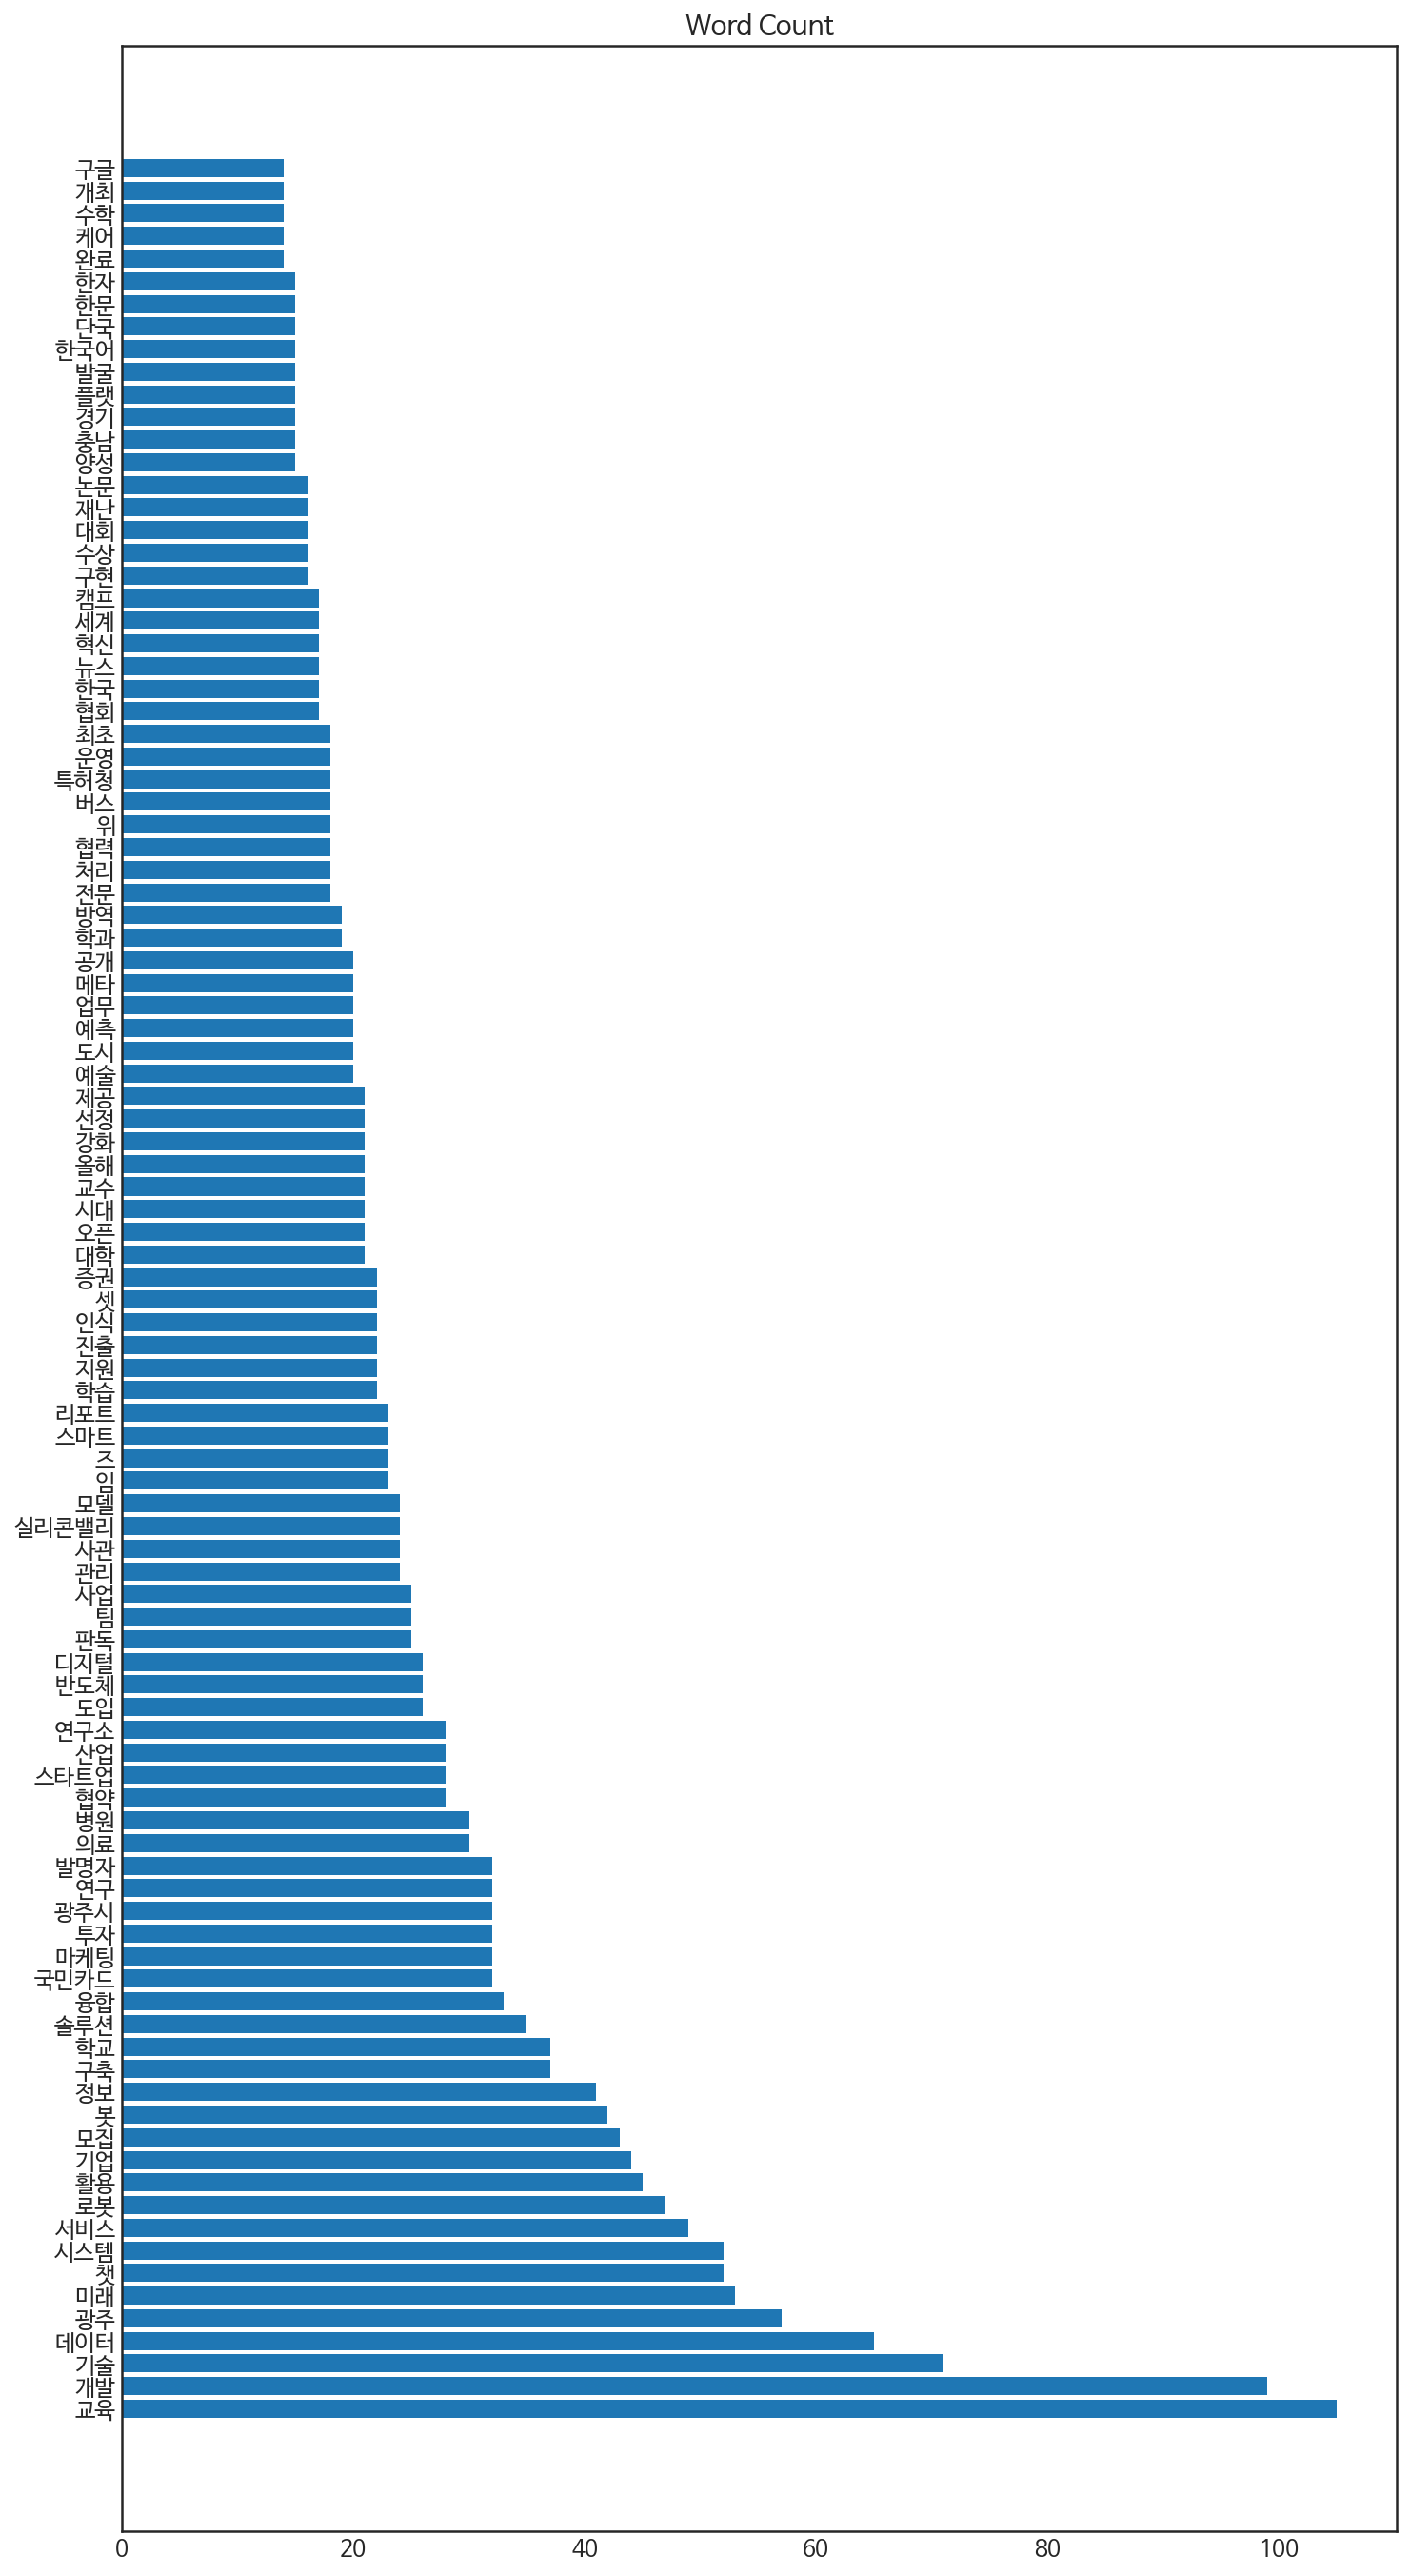

In [64]:
plt.rcParams['font.size'] = 12
y_pos = np.arange(len(top_news_nouns)) # y축 개수->100개
plt.figure(figsize = (12,24))
plt.barh(y_pos, top_news_nouns.values()) # plt.barh(y축, x축)
plt.title("Word Count")
plt.yticks(y_pos, top_news_nouns.keys()) # y축 눈금
plt.show()

### 트리맵 시각화

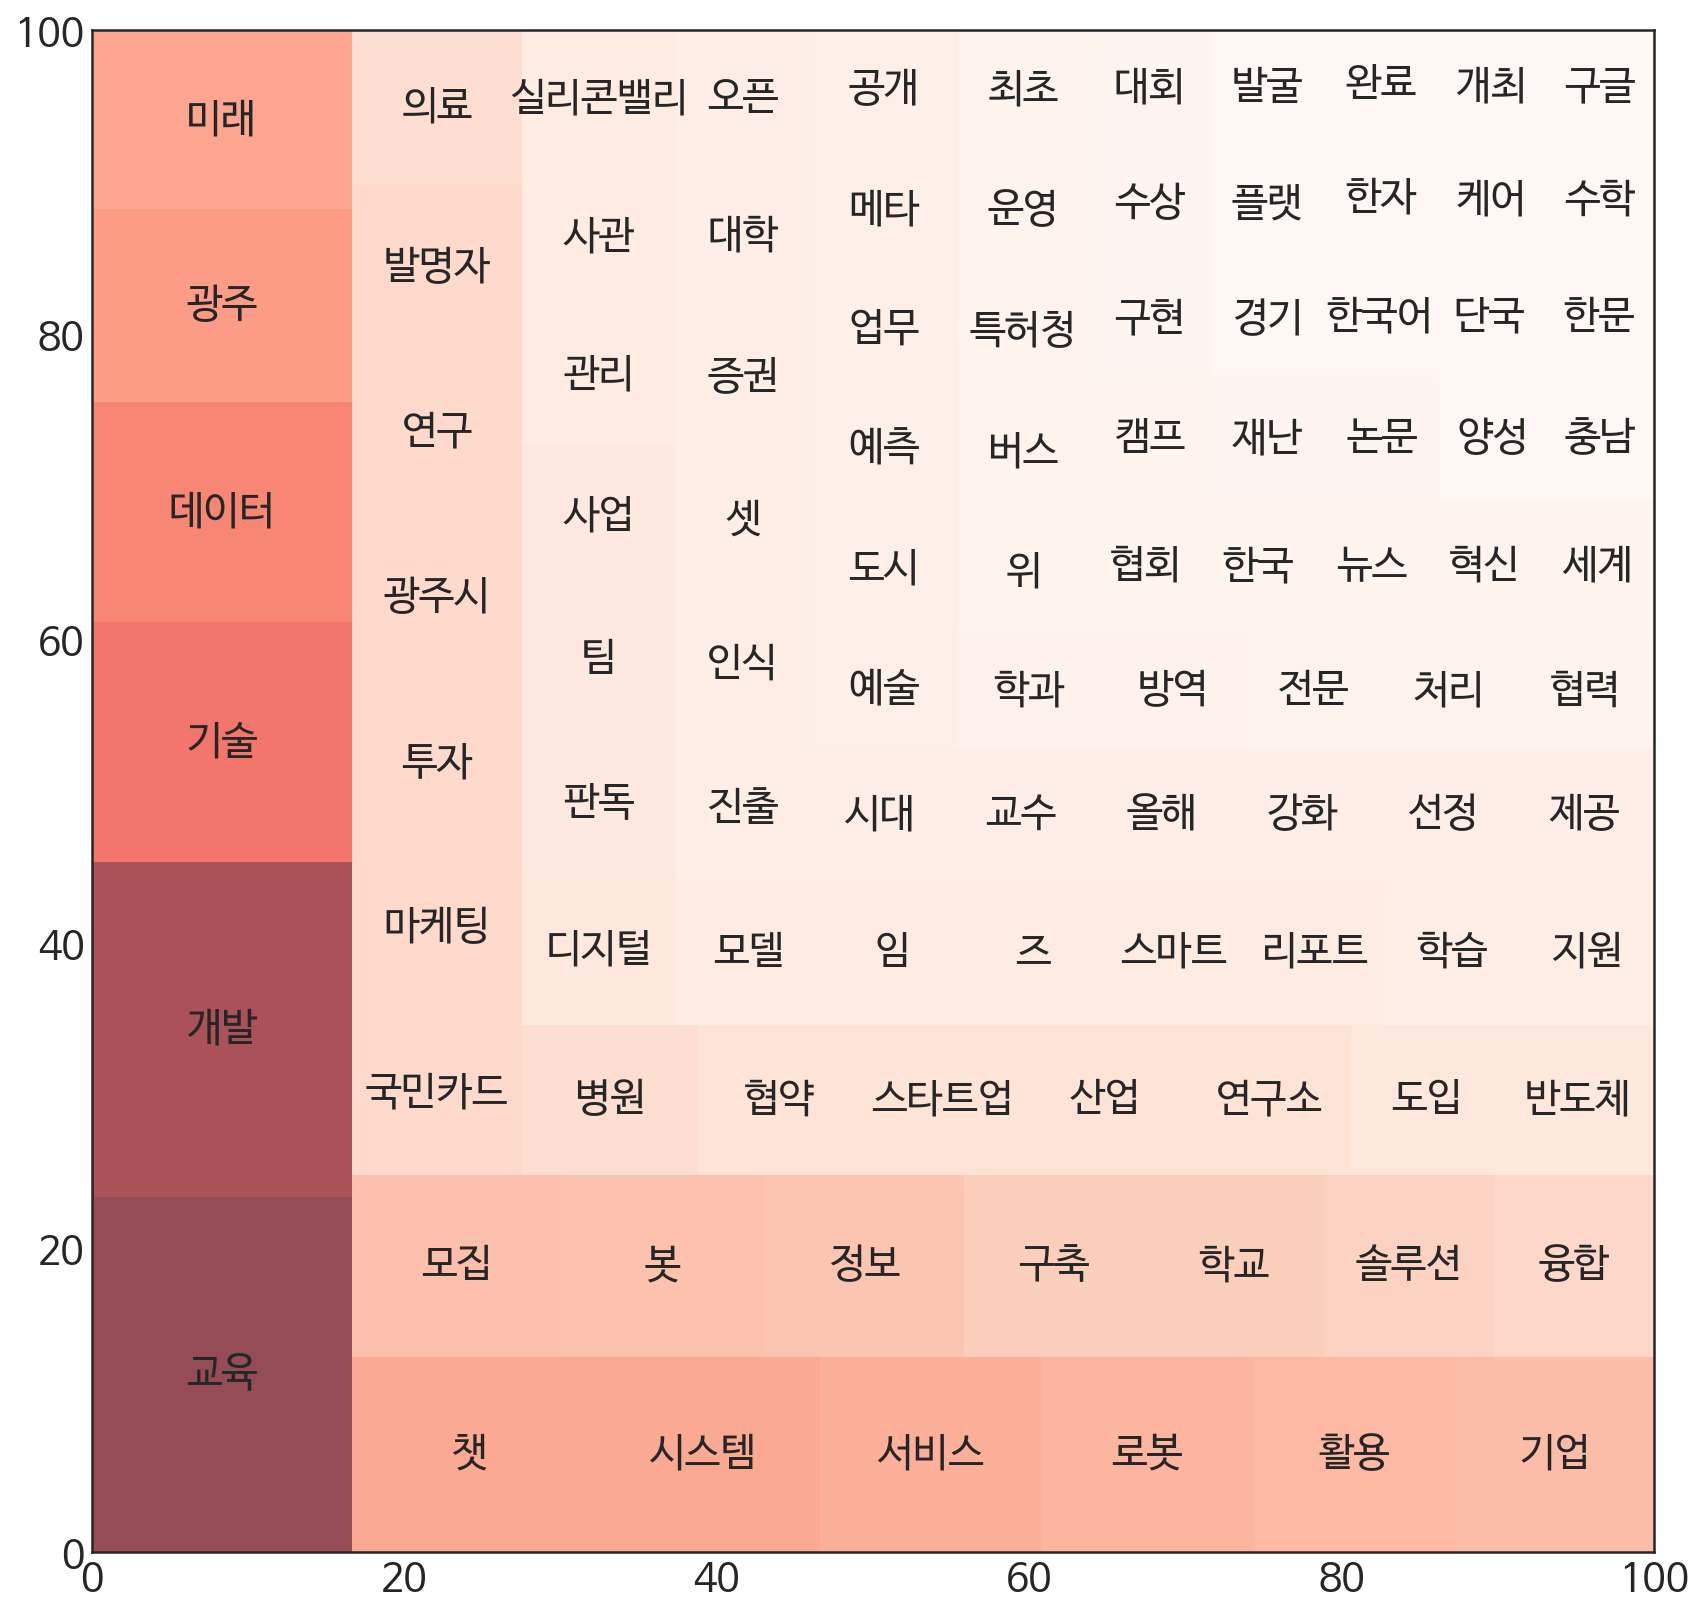

In [65]:
import squarify

# parameter 조정
plt.rcParams['figure.figsize'] = (14,14)
plt.rcParams['font.size'] = 20

# 정규화를 통한 컬러 조정 -> 색을 균등하게 하기 위해 빈도수에서 최소, 최대값으로 컬러 분포될 수 있도록 지정
norm = mpl.colors.Normalize(vmin = min(top_news_nouns.values()),
                            vmax = max(top_news_nouns.values()))

# 각각 무슨 컬러를 가질지를 리스트에 정규화를 통한 매칭의 결과값 저장(값, color)-> 값 클수록 컬러 진해짐
colors = [mpl.cm.Reds(norm(value)) for value in top_news_nouns.values()]

squarify.plot(label = top_news_nouns.keys(),
              sizes = top_news_nouns.values(),
              color = colors,
              alpha = 0.7)

### 워드클라우드 시각화

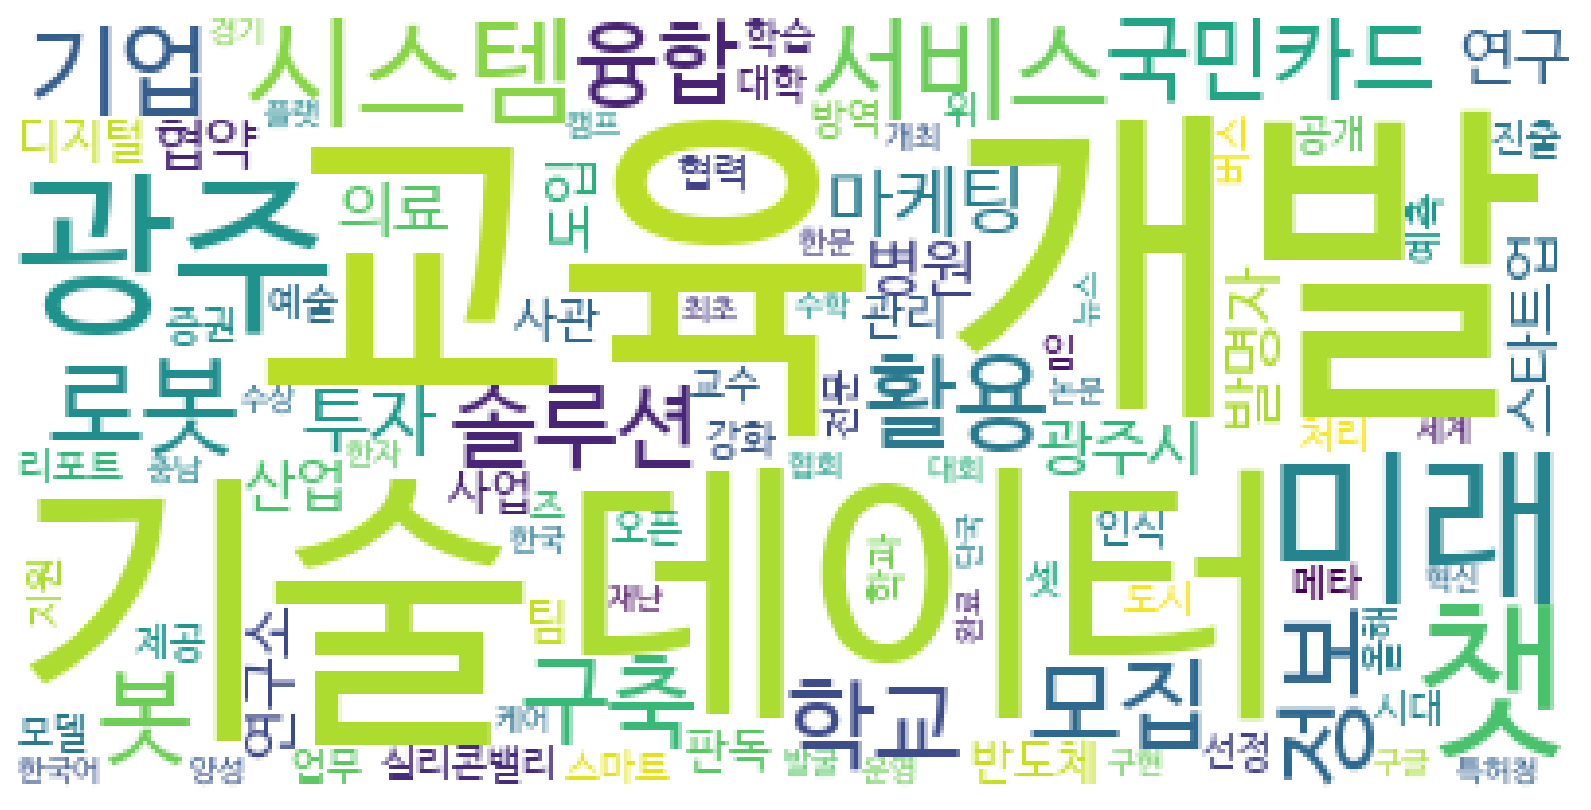

In [66]:
# wordcloud의 배경색, 폰트 설정
wc = WordCloud(background_color = 'white', font_path = '/font/NanumBarunGothic.ttf')
# top_reviews_nouns의 빈도수에 따라 wordcloud 생성
wc.generate_from_frequencies(top_news_nouns)

figure = plt.figure(figsize = (14,14))
ax = figure.add_subplot(1,1,1)
plt.axis('off')
ax.imshow(wc)
plt.show()

## 네이버 블로그 키워드 분석

### 네이버 블로그 검색 API

In [78]:
# 권한이 있는 사용자임을 명시
client_id = "B5YuqXvMWJ5YN3Rch9d4"
client_secret = "lhH_rcPIxu"

query = urllib.parse.quote(input("검색 질의 : "))
idx = 0
# parameters
display = 100
start = 1
end = 1000 # 네이버가 한번 검색했을 때 나오는 최대 건수
sort = 'sim' # 검색 결과 정렬 방법 - 정확도순(sim)으로 내림차순

# 결과를 넣을 데이터프레임 -> title, link ,description, bloggername, bloggerlink
blog_df = pd.DataFrame(columns=('Title', "Link", "Description", "Blogger Name", "Blogger link"))

for start_index in range(start, end, display):

  url = "https://openapi.naver.com/v1/search/blog?query=" + query \
        + '&display=' + str(display) + "&start=" + str(start_index) + "&sort=" + sort
  
  # 요청하기
  request = urllib.request.Request(url)
  request.add_header('X-Naver-Client-id', client_id)
  request.add_header('X-Naver-Client-Secret', client_secret)
  # 요청의 결과를 response에 저장
  response = urllib.request.urlopen(request)
  rescode = response.getcode() # 코드 정상적으로 되었는지 코드 반환, 200번이면 정상 아니면 비정상

  # 요청의 정상인 경우
  if(rescode == 200):
    response_body = response.read() # 정상이면 결과 읽어오기
    response_dict = json.loads(response_body.decode('utf-8'))
    # json으로 결과가 오기 때문에 디코드를 통해 utf-8로 디코딩
    items = response_dict['items'] 
    # 우리가 필요한건 개별 검색 결과인 items -> 안에 title, originallink, link ,description, pubDate포함
    for item_index in range(0, len(items)):
      remove_tag = re.compile('<.*?>')
      
      # title
      title = re.sub(remove_tag, '',items[item_index]['title'])
      # 불필요한 태그에 대한 특수문자 제거

      # link
      link = items[item_index]['link']

      # description
      description = re.sub(remove_tag, "",items[item_index]['description'])
      # title과 마찬가지로 불필요한 특수문자 제거

      # Bloggername
      bloggername = items[item_index]['bloggername']

      # Bloggerlink
      bloggerlink = items[item_index]['bloggerlink']


      # 나온 값을 데이터프레임(blog_df)에 넣기
      blog_df.loc[idx] = [title, link, description, bloggername, bloggerlink]
      # 다음 행에 넣게끔 1씩 증가
      idx += 1 

  # 요청이 비정상인 경우
  else:
    print("Error Code : " + rescode)

blog_df 

검색 질의 : 인공지능


,Title,Link,Description,Blogger Name,Blogger link
0,AI학과 인공지능을 배우는 학교,https://blog.naver.com/dhdutk2014/222986766362,2년 전 가천대학교에서 최초로 인공지능학과인 AI학과를 신설했습니다. 그 당시만 하...,♥ 좋은 생각 ♥,blog.naver.com/dhdutk2014
1,인공지능 스피커 셋톱박스 요약(SK KT LG U플러스...,https://blog.naver.com/kevokevo/222981710262,인공지능 스피커 셋톱박스 요약(SK KT LG U플러스 기가지니3 A 누구(NUGU...,COA,blog.naver.com/kevokevo
2,"키워드 - 인플레이션, 경기침체, 인력감축 그리고 인공지능",https://blog.naver.com/simon9627/222987680438,키워드를 #인플레이션 #경기침체 #인력감축 #인공지능 등으로 발표하였습니다. htt...,스마트메이커,blog.naver.com/simon9627
3,줄타고 농작물을 수확하는 인공지능 로봇,https://blog.naver.com/jjy0501/222976501338,(Credit: Agrist) 로봇 기술과 인공지능 기술이 발전하면서 최근 농업 분...,고든의 블로그,blog.naver.com/jjy0501
4,캠핑전기매트 인공지능 핫써클로 스마트한 겨울캠핑난방 준비물,https://blog.naver.com/dldyddl/222974077408,이제는 인공지능 기능으로 주변 기온에 따라 알아서 온도조절까지 해 주는 핫써클 AI...,용쓰패밀리와 함께 떠나는 캠핑&여행이야기,blog.naver.com/dldyddl
...,...,...,...,...,...
995,인공지능 AI 챗봇 이제 솔트룩스 톡봇으로 간편하게 관리하자,https://blog.naver.com/niedlichej/222763668325,인공지능 요소기술을 확장해서 맞춤형 최적의 비즈니스까지 제공 해 주는 똑똑한 솔트룩...,감성 IT 리뷰어 꽃길유치원생,blog.naver.com/niedlichej
996,"놀이로 배우는 인공지능, 프로젝트 학습서",https://blog.naver.com/rabbitt_chu/222955964740,"놀이로 배우는 인공지능 저자 곽소아,김서진,양정현,이현주,장윤재 출판 제이펍 발매 ...",래빗chu의 Lovely Days♡,blog.naver.com/rabbitt_chu
997,"1월에 보고 있는 뉴스랑 주식 재료매매 - 전세,반도체, 인공지능",https://blog.naver.com/dolcheblog/222980127420,인공지능 (CHATGPT) https://www.reuters.com/technol...,돌체 블로그,blog.naver.com/dolcheblog
998,인공지능으로 수치모델의 계산 시간 한계를 극복해 보자!,https://blog.naver.com/kma_131/222518183863,"1 왜, 인공지능인가? 수치모델은 대기현상을 나타내는 복잡한 물리방정식의 집합입니다...",대한민국 기상청 대표 블로그: 생기발랄,blog.naver.com/kma_131


In [68]:
blog = []
for b in blog_df.Description:
  blog.append(b)
print(blog[:5])

['2년 전 가천대학교에서 최초로 인공지능학과인 AI학과를 신설했습니다. 그 당시만 하더라도 처음... 주변에서 이제는 심심치 않게 인간 대신에 로봇 또는 인공지능을 기반으로 제품이 자체적으로 운영되고 있는... ', '인공지능 스피커 셋톱박스 요약(SK KT LG U플러스 기가지니3 A 누구(NUGU) 클로바AI) 인터넷 tv가 필수인 시대, 요즘은 인터넷을 새로 가입하거나 재약정을 하면 인공지능 스피커 셋톱박스로 신청을 할 수... ', '키워드를 #인플레이션 #경기침체 #인력감축 #인공지능 등으로 발표하였습니다. https://www.visualcapitalist.... 인공지능 인력감축의 영향에는 #인공지능 기술 발달도 어느정도 영향을 미칠 것으로 보입니다. 이미... ', '(Credit: Agrist) 로봇 기술과 인공지능 기술이 발전하면서 최근 농업 분야에서도 이를 응용한 자동화... 카메라와 인공지능 인식 시스템을 이용해 작물 (이 경우는 피망)을 인식하고 수확하는데, 작업 속도는... ', '이제는 인공지능 기능으로 주변 기온에 따라 알아서 온도조절까지 해 주는 핫써클 AI 인공지능 캠핑전기매트를 소개해 드립니다. 핫써클 AI 인공지능 캠핑전기매트 오픈! 저는 더블사이즈를 소개해 드릴텐데요.... ']


### 형태소 분석을 이용한 명사 추출


In [70]:
tagger = Mecab() # Mecab을 이용한 형태소 분석
blog_nouns = []
for b in blog:
  for noun in tagger.nouns(b):
    if noun not in stop_words:
      blog_nouns.append(noun)
print(blog_nouns[:10])

['가천', '대학교', '최초', '학과', '학과', '신설', '당시', '처음', '주변', '이제']


### 단어 빈도수 측정

In [73]:
blog_nouns_counter = Counter(blog_nouns)
top_blog_nouns = dict(blog_nouns_counter.most_common(100))
top_blog_nouns

{'기술': 276,
 '데이터': 183,
 '교육': 151,
 '활용': 131,
 '인간': 120,
 '로봇': 106,
 '학습': 105,
 '관련': 100,
 '산업': 96,
 '개발': 92,
 '사람': 91,
 '시대': 90,
 '서비스': 90,
 '그림': 86,
 '정보': 77,
 '봇': 77,
 '기업': 74,
 '우리': 69,
 '생각': 68,
 '발전': 67,
 '챗': 67,
 '러닝': 67,
 '미래': 67,
 '과학': 66,
 '코딩': 63,
 '연구': 61,
 '사용': 60,
 '보청기': 60,
 '프로그램': 57,
 '시스템': 56,
 '학교': 55,
 '최근': 53,
 '소프트웨어': 51,
 '소개': 50,
 '진행': 50,
 '광주': 49,
 '디지털': 49,
 '컴퓨터': 48,
 '과정': 47,
 '이번': 47,
 '학과': 45,
 '주': 44,
 '시작': 44,
 '분석': 44,
 '인식': 42,
 '지원': 41,
 '관심': 41,
 '아이': 41,
 '시간': 41,
 '능력': 41,
 '이미지': 40,
 '가능': 40,
 '수업': 40,
 '강의': 39,
 '기능': 38,
 '학생': 38,
 '사회': 37,
 '오늘': 37,
 '신경망': 37,
 '세상': 36,
 '자동': 35,
 '구글': 35,
 '때': 35,
 '전문': 35,
 '대회': 35,
 '대학교': 34,
 '내용': 34,
 '음성': 33,
 '스마트': 33,
 '이야기': 33,
 '대화': 32,
 '필요': 32,
 '영상': 32,
 '버스': 32,
 '문제': 32,
 '저': 31,
 '국내': 31,
 '한국': 31,
 '특허': 31,
 '모델': 30,
 '알고리즘': 30,
 '사업': 30,
 '솔루션': 30,
 '운영': 29,
 '제공': 29,
 '머신': 29,
 '수학': 29,
 '메타': 29,
 '직업': 29,

### 단어 빈도 시각화

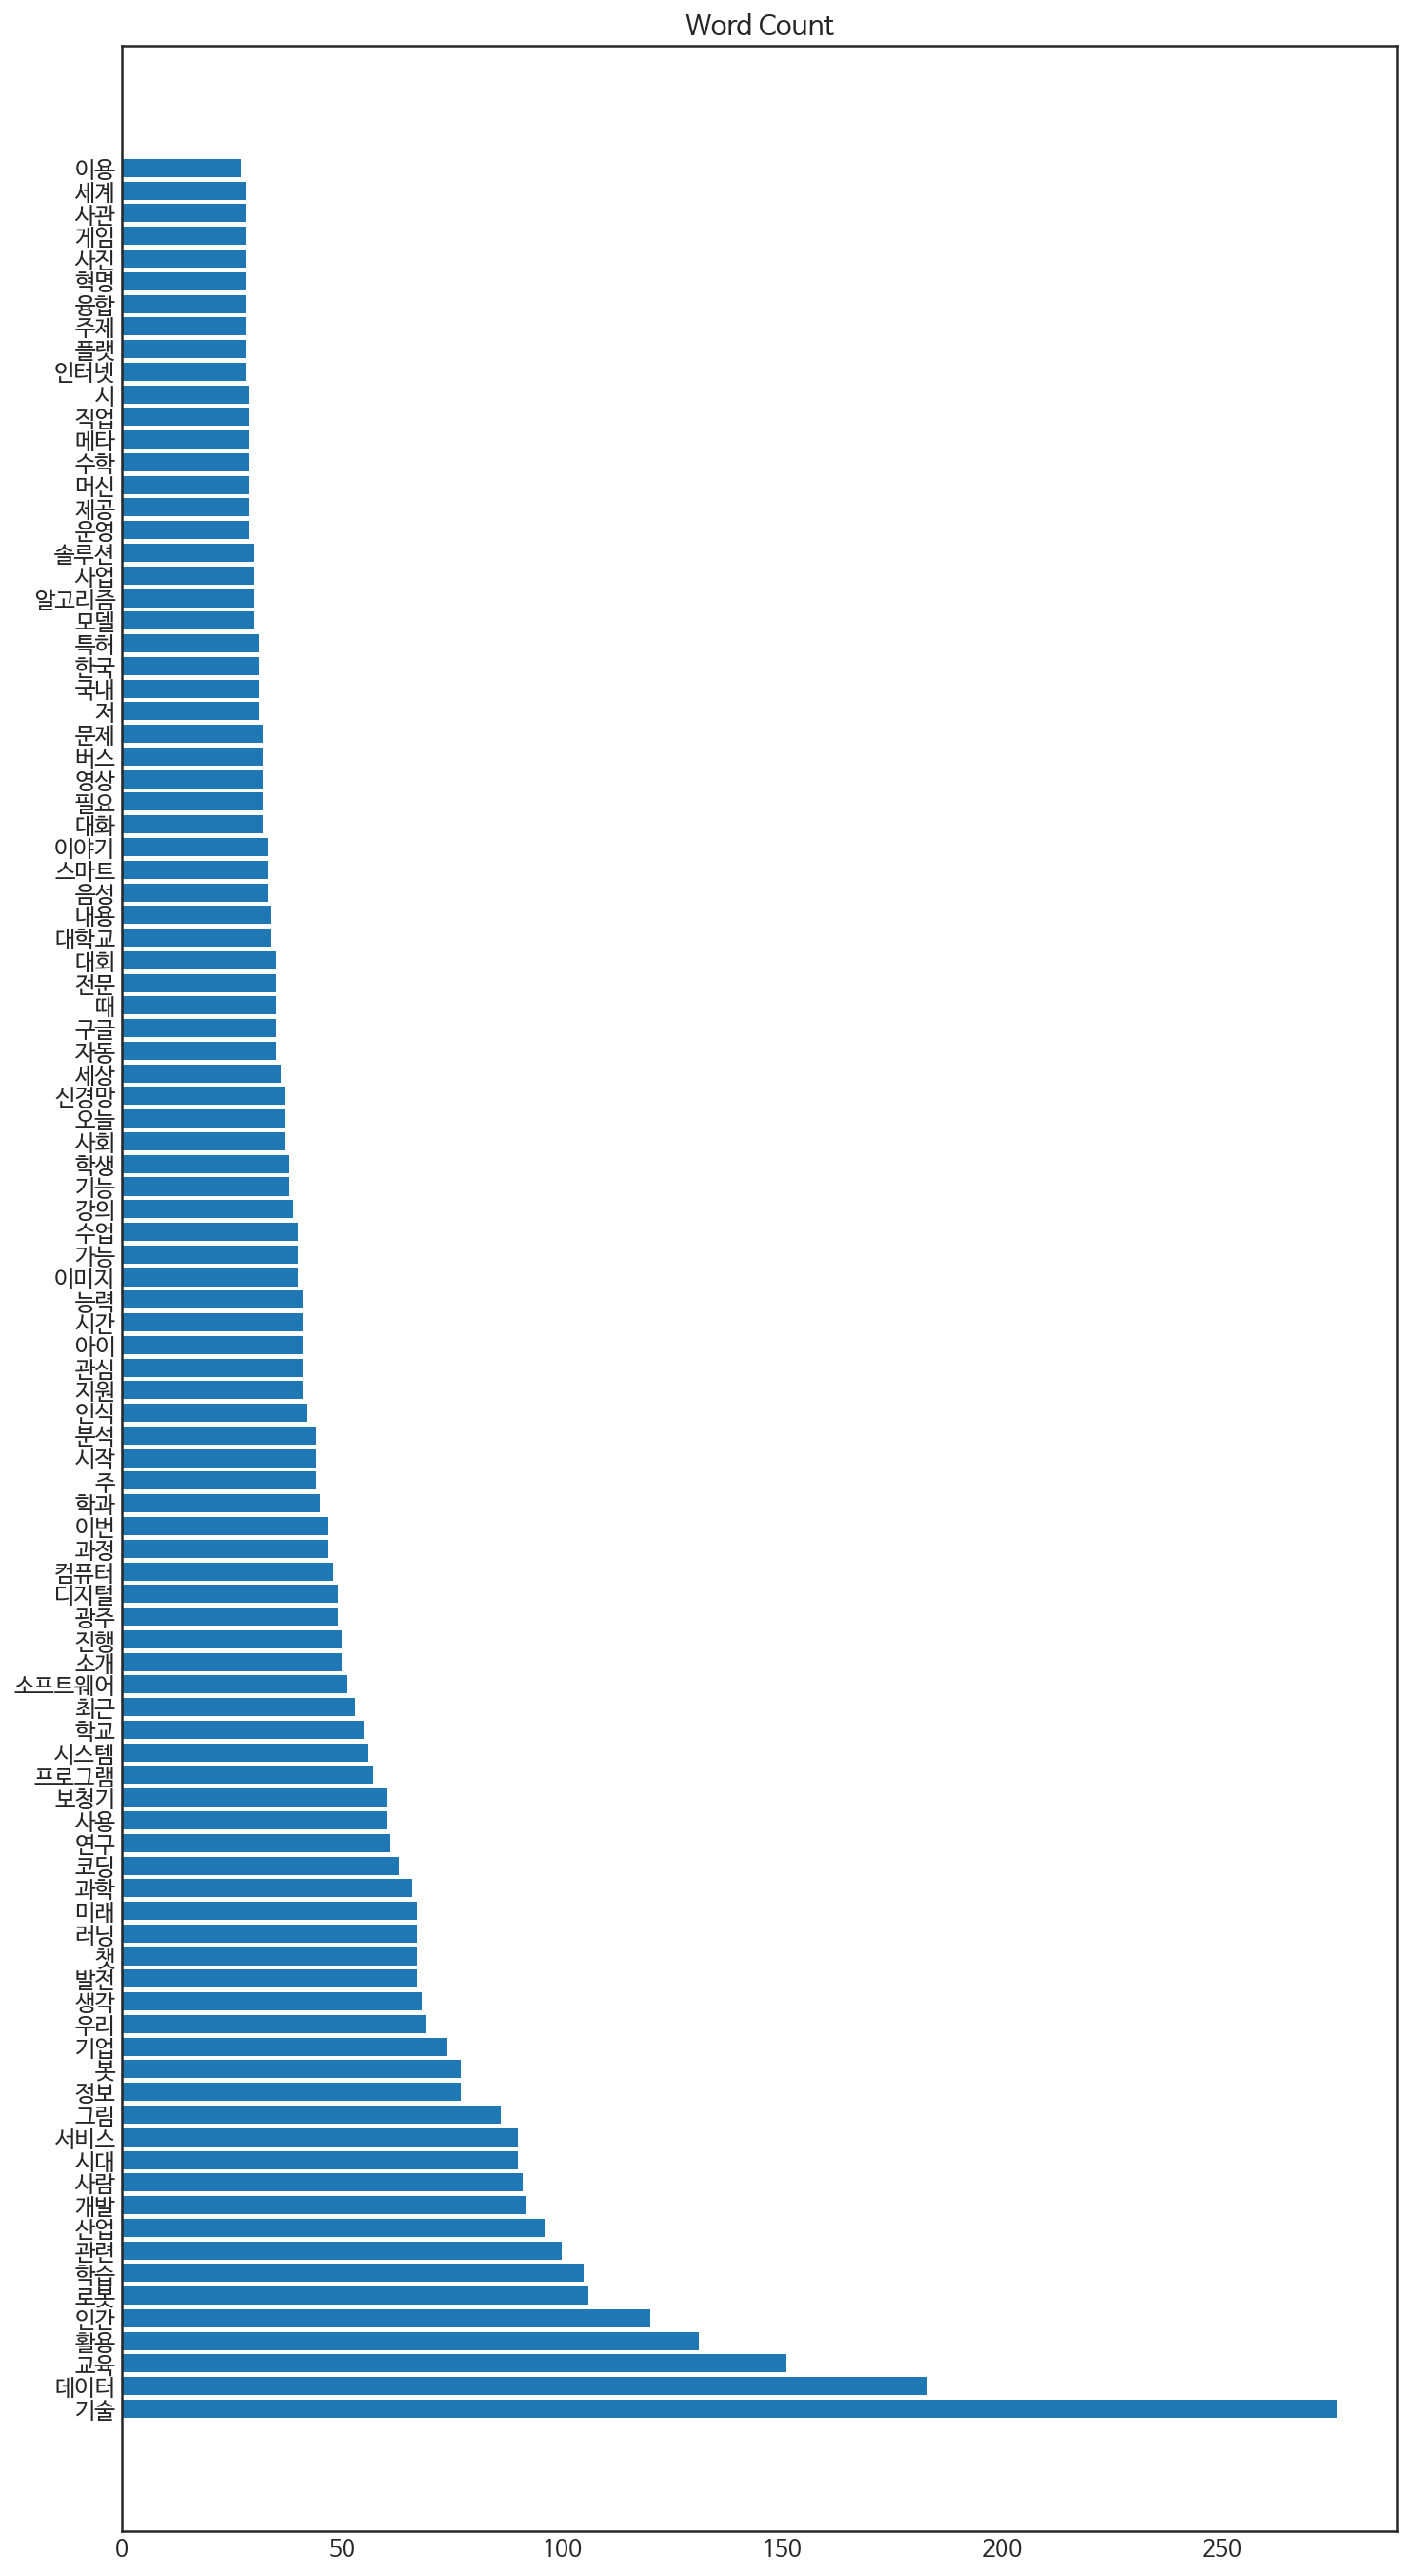

In [74]:
plt.rcParams['font.size'] = 12
y_pos = np.arange(len(top_blog_nouns)) # y축 개수->100개
plt.figure(figsize = (12,24))
plt.barh(y_pos, top_blog_nouns.values()) # plt.barh(y축, x축)
plt.title("Word Count")
plt.yticks(y_pos, top_blog_nouns.keys()) # y축 눈금
plt.show()

### 트리맵 시각화

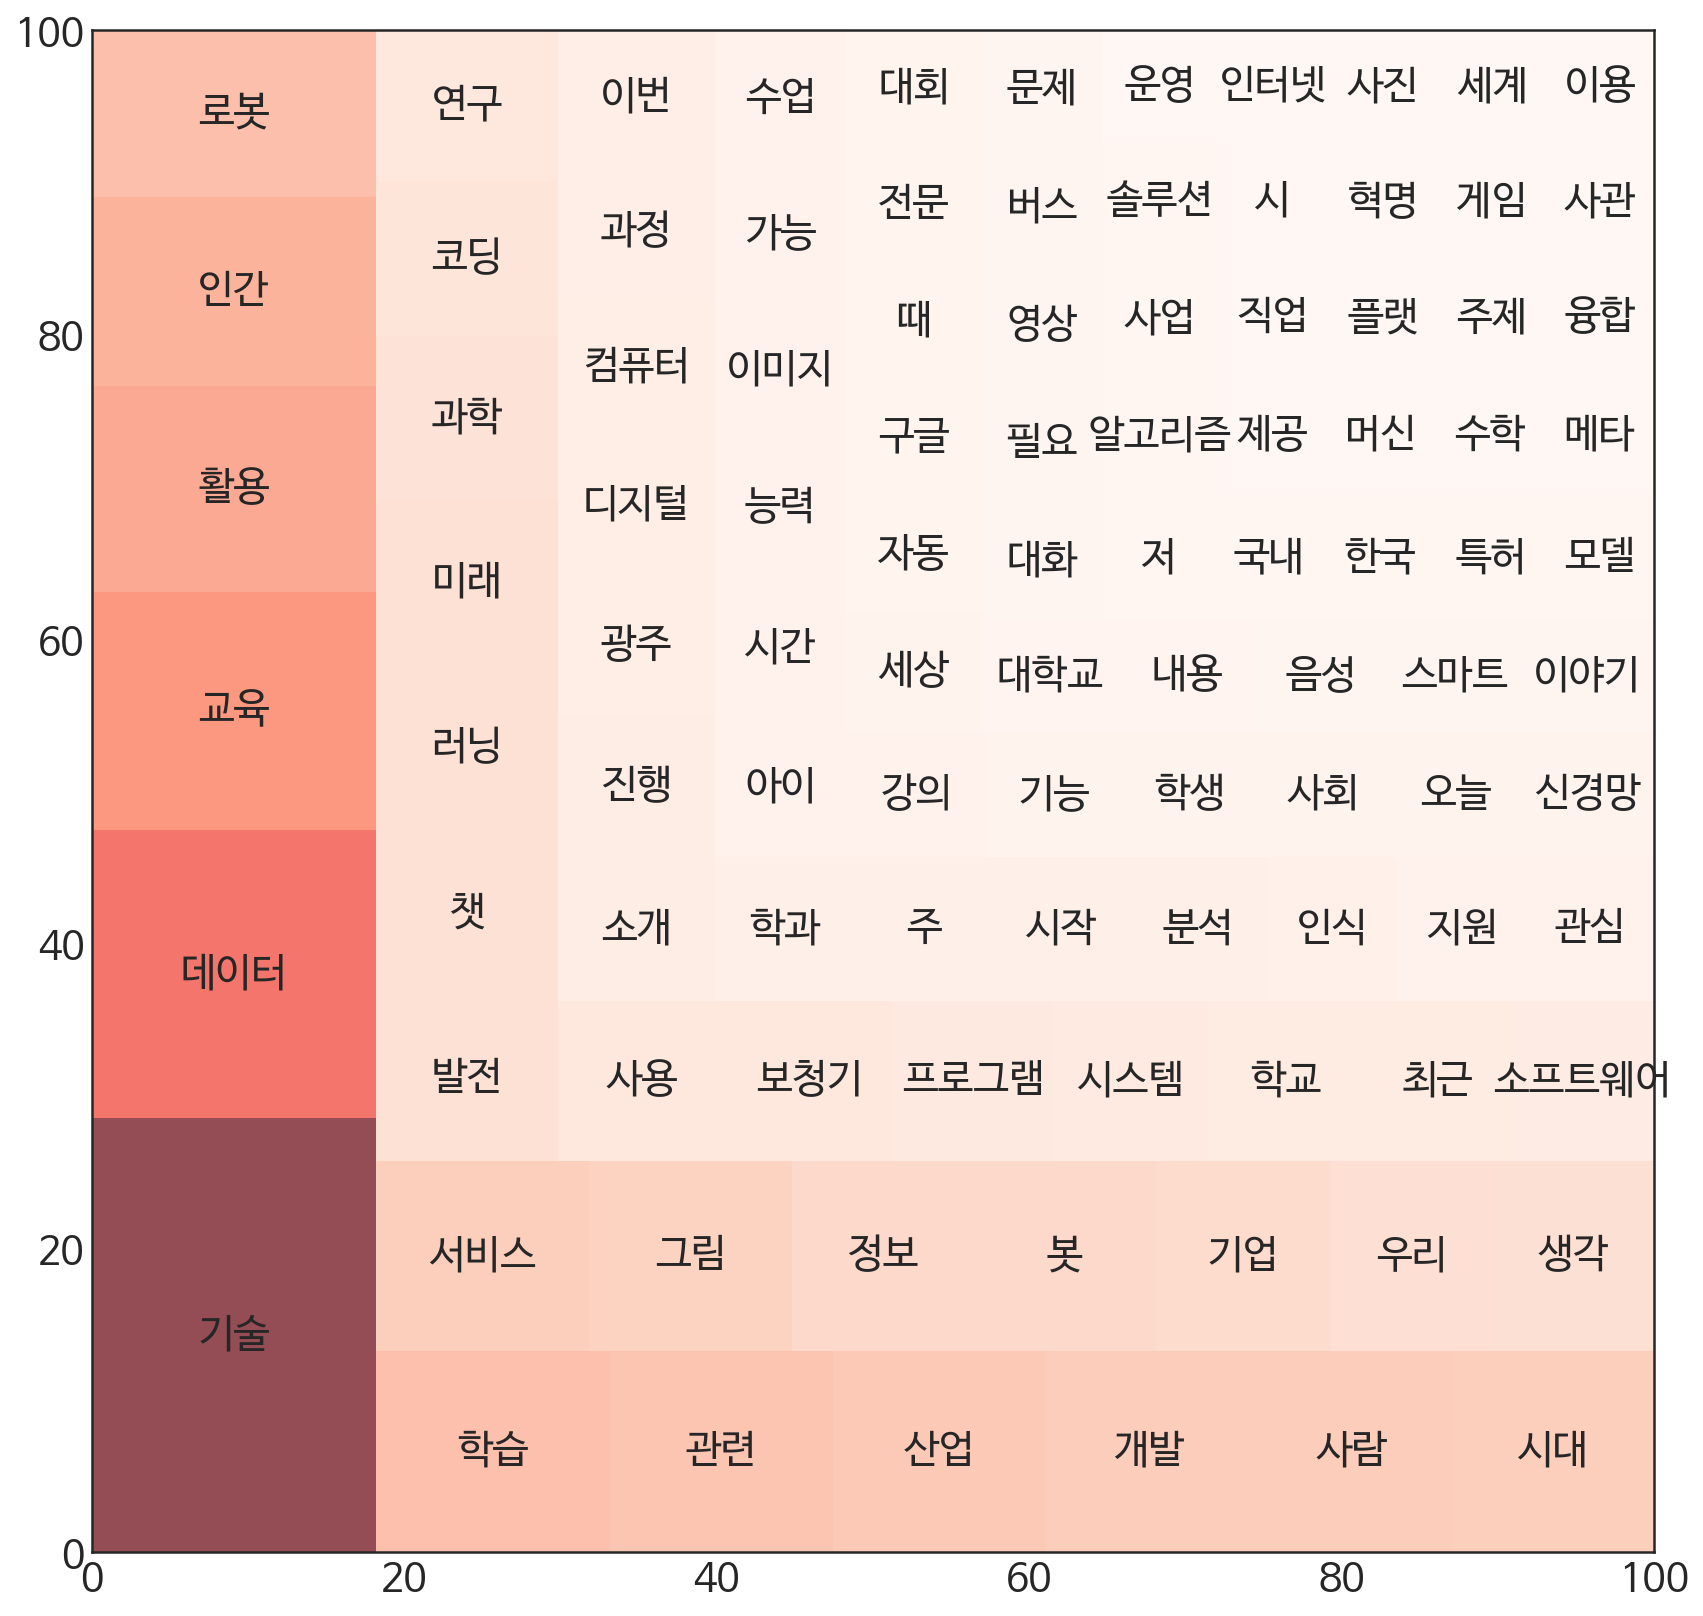

In [75]:
import squarify

# parameter 조정
plt.rcParams['figure.figsize'] = (14,14)
plt.rcParams['font.size'] = 20

# 정규화를 통한 컬러 조정 -> 색을 균등하게 하기 위해 빈도수에서 최소, 최대값으로 컬러 분포될 수 있도록 지정
norm = mpl.colors.Normalize(vmin = min(top_blog_nouns.values()),
                            vmax = max(top_blog_nouns.values()))

# 각각 무슨 컬러를 가질지를 리스트에 정규화를 통한 매칭의 결과값 저장(값, color)-> 값 클수록 컬러 진해짐
colors = [mpl.cm.Reds(norm(value)) for value in top_blog_nouns.values()]

squarify.plot(label = top_blog_nouns.keys(),
              sizes = top_blog_nouns.values(),
              color = colors,
              alpha = 0.7)

### 워드클라우드 시각화

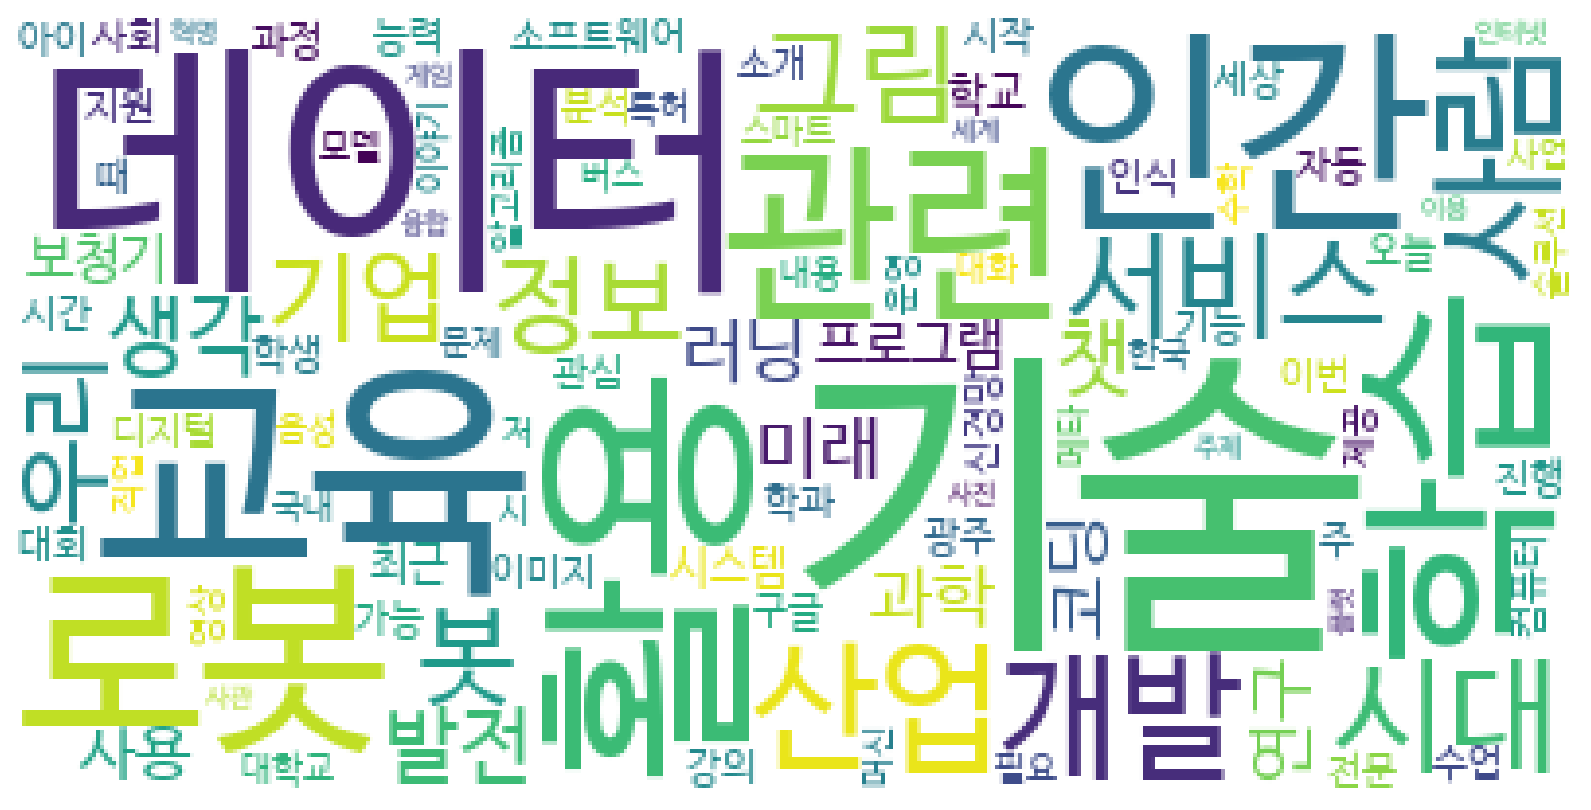

In [76]:
# wordcloud의 배경색, 폰트 설정
wc = WordCloud(background_color = 'white', font_path = '/font/NanumBarunGothic.ttf')
# top_reviews_nouns의 빈도수에 따라 wordcloud 생성
wc.generate_from_frequencies(top_blog_nouns)

figure = plt.figure(figsize = (14,14))
ax = figure.add_subplot(1,1,1)
plt.axis('off')
ax.imshow(wc)
plt.show()